# Porto Seguro’s Safe Driver Prediction

 ## Data Pre-processing+FE +Baseline Model

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

#### Data Description:

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

#### File descriptions:
train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
test.csv contains the test data.
sample_submission.csv is submission file showing the correct format.

#### EDA Summary:

    1. The data is extremely imbalanced with only 4% of positive class and 96% of negative class.
    2. The missing values are very significant for certain categorical and continuous features which needs to be handled.
    3. There is no significant correlation between the features. The maximum correlation value seen is 0.64 which is fine.
    4. For most of the categorical features (ps_car_01_cat,ps_car_03_cat,ps_ind_05_cat,ps_car_07_cat), the values are dominated by a single feature or a couple of features.
    5. Some of the binary features (ps_ind_17_bin,ps_ind_07_bin,ps_ind_09_bin) are again dominated by a single value (0 or 1)
    6. For both binary and category, There is a small difference in the insurance claim % for certain feature values which could be used to predict the classes with accuracy.
    7. The continuous features are again dominated by certain values and the spread is not very uniform.
    8. For continuous features, The data distribution between the two classes are slightly different from each other which could be leveraged to predict the classes.
    9. Since the data is extremely imbalanced, we cant be very conclusive with the data plots but we can get an overall idea about it.
    10. There is no duplicate data or null values present in the dataset.

#### Performance Metric:

Normalized gini co-efficient is the metric used to evaluate the model. It is mainly useful for imbalanced datasets where the metric basically focuses on the prediction probability. For a binary class, if the prediction probability is high for the destined class label, then the gini co-efficient will be more for the model and vice versa. 

So for the business problem in question, we need to be sure that the particular customer will claim insurance or not else this might cause us to lose customers. Normalised Gini co-efficient tells us how sure our model can detect a customer who will claim insurance considering the prediction probability. 

The Normalized Gini Co-efficient ranges between 0 and 1. 

The AUC and Gini Co-efficient is related using the formula : Gini = 2*AUC – 1

In [6]:
#importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingCVClassifier
from lightgbm import LGBMClassifier  
import re
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [1]:
#Google collab load

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab_Notebooks
!ls

In [10]:
#Loading the data into csv file

data=pd.read_csv('train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
#Seggreagating the class labels seperately

temp_y=data['target']
temp_x=data.drop(['id','target'],axis=1)

In [ ]:
## Missing values % in the data

miss_columns=temp_x.eq(-1).sum()
colname=temp_x.columns
for i in range(len(miss_columns)):
    if miss_columns[i]!=0:
        print("The missing value % in column",colname[i],"is", miss_columns[i]*100/595212,'%')

## Train-Test Split

In [11]:
#Data split for train and test using Stratify

data_y=data['target']
data_x=data.drop(['id','target'],axis=1)
#data_x.head()
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y, test_size=0.33, stratify=data_y,random_state=42)

## Data Pre-Processing

### Categorical feature imputation - Model-based imputation for categorical missing features less than 1%

The Categorical features having missing features less than 1% are imputed whereas missing value counts greater than 1% are considered as a seperate category itself. Imputation method followed here is "most frequent" where the missing values will be imputed with the maximum frequency value from the dataset.

In [ ]:
#Replacing missing values by nan to support imputation.

X_train['ps_ind_02_cat']=X_train['ps_ind_02_cat'].replace(-1,np.nan)
X_train['ps_ind_04_cat']=X_train['ps_ind_04_cat'].replace(-1,np.nan)
X_train['ps_ind_05_cat']=X_train['ps_ind_05_cat'].replace(-1,np.nan)
X_train['ps_car_01_cat']=X_train['ps_car_01_cat'].replace(-1,np.nan)
X_train['ps_car_02_cat']=X_train['ps_car_02_cat'].replace(-1,np.nan)
X_train['ps_car_09_cat']=X_train['ps_car_09_cat'].replace(-1,np.nan)

X_test['ps_ind_02_cat']=X_test['ps_ind_02_cat'].replace(-1,np.nan)
X_test['ps_ind_04_cat']=X_test['ps_ind_04_cat'].replace(-1,np.nan)
X_test['ps_ind_05_cat']=X_test['ps_ind_05_cat'].replace(-1,np.nan)
X_test['ps_car_01_cat']=X_test['ps_car_01_cat'].replace(-1,np.nan)
X_test['ps_car_02_cat']=X_test['ps_car_02_cat'].replace(-1,np.nan)
X_test['ps_car_09_cat']=X_test['ps_car_09_cat'].replace(-1,np.nan)


In [ ]:
len(X_test)

196420

In [ ]:
#Imputing using most frequent/mode method for categorical feature.

cat_imp=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_cat_imp=cat_imp.fit_transform(X_train)
X_train[:]=X_train_cat_imp



cat_imp_test=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_test_cat_imp=cat_imp_test.fit_transform(X_test)
X_test[:]=X_test_cat_imp

In [ ]:
#Missing value % check

miss_columns=X_train.eq(-1).sum()
colname=X_train.columns
for i in range(len(miss_columns)):
    if miss_columns[i]!=0:
        print("The missing value % in column",colname[i],"is", miss_columns[i]*100/595212,'%')
        

The missing value % in column ps_reg_03 is 12.135508020671626 %
The missing value % in column ps_car_03_cat is 46.29308548886783 %
The missing value % in column ps_car_05_cat is 29.978730267534928 %
The missing value % in column ps_car_07_cat is 1.2877764561198364 %
The missing value % in column ps_car_11 is 0.0005040220963287031 %
The missing value % in column ps_car_14 is 4.798626371780139 %


Only categories having missing values greater than 1% and continuous values are present. 

In [ ]:
X_train["ps_ind_05_cat"].value_counts()

0.0    357571
6.0     13931
4.0     12263
1.0      5567
3.0      5501
2.0      2851
5.0      1108
Name: ps_ind_05_cat, dtype: int64

### Numerical feature imputation

For Numerical features, the missing values will be imputed with model-based method 'Knn-Imputer'.

In [ ]:
#Replacing missing values with 'nan' for Continuous features.

X_train['ps_car_11']=X_train['ps_car_11'].replace(-1,np.nan)
X_train['ps_car_12']=X_train['ps_car_12'].replace(-1,np.nan)
X_train['ps_car_14']=X_train['ps_car_14'].replace(-1,np.nan)
X_train['ps_reg_03']=X_train['ps_reg_03'].replace(-1,np.nan)


X_test['ps_car_11']=X_test['ps_car_11'].replace(-1,np.nan)
X_test['ps_car_12']=X_test['ps_car_12'].replace(-1,np.nan)
X_test['ps_car_14']=X_test['ps_car_14'].replace(-1,np.nan)
X_test['ps_reg_03']=X_test['ps_reg_03'].replace(-1,np.nan)


In [ ]:
#Imputation done with Knn-model based method for continuous features. 

imputer = KNNImputer(n_neighbors=3)
X_train_fit=imputer.fit_transform(X_train)


imputer_test = KNNImputer(n_neighbors=3)
X_test_fit=imputer_test.fit_transform(X_test)

In [ ]:
X_train[:]=X_train_fit
X_test[:]=X_test_fit

In [ ]:
#Saving the final imputed data into a file

#X_train.to_csv('X_imputed.csv')
#X_test.to_csv('X_imputed_test.csv')

In [ ]:
#Reading the final imputed file


X_imp_train=pd.read_csv('X_imputed.csv')
X_imp_train.head()


X_imp_test=pd.read_csv('X_imputed_test.csv')
X_imp_test.head()


,Unnamed: 0,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,74260,3.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,6.0,0.0,5.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
1,319443,4.0,2.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0
2,550791,5.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0
3,302234,1.0,2.0,1.0,1.0,4.0,0.0,0.0,1.0,0.0,...,7.0,2.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0
4,15504,2.0,1.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.0,4.0,3.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
X_imp_train.isnull().sum().sum()
X_imp_test.isnull().sum().sum()

0

In [ ]:
X_imp_train.shape

(398792, 58)

In [ ]:
X_imp_train['ps_ind_02_cat'].value_counts()

1.0    289469
2.0     82851
3.0     18833
4.0      7639
Name: ps_ind_02_cat, dtype: int64

### One hot Encoding of Categorical Features-Data Preprocessing

One hot Encoding is performed on Categorical features.

In [ ]:
colu=X_imp_train[['ps_ind_02_cat','ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin','ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin','ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat','ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin','ps_calc_19_bin', 'ps_calc_20_bin']].columns

In [ ]:
X_imp_train

,Unnamed: 0,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,12832,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,7.0,3.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0
1,201839,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,5.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0
2,575286,4.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,3.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0
3,79132,1.0,3.0,6.0,1.0,0.0,0.0,0.0,1.0,0.0,...,7.0,2.0,1.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26497,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,2.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398787,120195,3.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,8.0,2.0,3.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0
398788,438004,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,3.0,2.0,11.0,0.0,1.0,1.0,0.0,1.0,0.0
398789,72635,2.0,1.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,...,8.0,0.0,2.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0
398790,129319,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#Creating One hot encoding of Categorical features/Binary Features and merging them into a single file.

for i in tqdm(colu):
    temp=pd.get_dummies(X_imp_train[i],prefix=i)
    #print(temp)
    X_imp_train=X_imp_train.merge(temp,left_index=True,right_index=True)
    
    
for i in tqdm(colu):
    temp=pd.get_dummies(X_imp_test[i],prefix=i)
    #print(temp)
    X_imp_test=X_imp_test.merge(temp,left_index=True,right_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  8.69it/s]


In [ ]:
print(X_imp_train.columns)
print(X_imp_test.columns)

Index(['Unnamed: 0', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin',
       ...
       'ps_calc_16_bin_0.0', 'ps_calc_16_bin_1.0', 'ps_calc_17_bin_0.0',
       'ps_calc_17_bin_1.0', 'ps_calc_18_bin_0.0', 'ps_calc_18_bin_1.0',
       'ps_calc_19_bin_0.0', 'ps_calc_19_bin_1.0', 'ps_calc_20_bin_0.0',
       'ps_calc_20_bin_1.0'],
      dtype='object', length=270)
Index(['Unnamed: 0', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin',
       ...
       'ps_calc_16_bin_0.0', 'ps_calc_16_bin_1.0', 'ps_calc_17_bin_0.0',
       'ps_calc_17_bin_1.0', 'ps_calc_18_bin_0.0', 'ps_calc_18_bin_1.0',
       'ps_calc_19_bin_0.0', 'ps_calc_19_bin_1.0', 'ps_calc_20_bin_0.0',
       'ps_calc_20_bin_1.0'],
      dtype='object', length=270)


In [ ]:
# Dropping the Categorical features which are not required as they are one-hot encoded already.

for i in colu:
    X_imp_train=X_imp_train.drop(i,axis=1)
    
for i in colu:
    X_imp_test=X_imp_test.drop(i,axis=1)

In [ ]:
print(X_imp_train.shape)

print(X_imp_test.shape)

(398792, 239)
(196420, 239)


In [ ]:
X_imp_train

,Unnamed: 0,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,...,ps_calc_16_bin_0.0,ps_calc_16_bin_1.0,ps_calc_17_bin_0.0,ps_calc_17_bin_1.0,ps_calc_18_bin_0.0,ps_calc_18_bin_1.0,ps_calc_19_bin_0.0,ps_calc_19_bin_1.0,ps_calc_20_bin_0.0,ps_calc_20_bin_1.0
0,12832,0.0,1.0,0.0,7.0,0.8,0.4,0.790569,3.0,0.316228,...,0,1,0,1,1,0,1,0,1,0
1,201839,0.0,2.0,0.0,10.0,0.9,0.3,0.633443,3.0,0.400000,...,0,1,0,1,1,0,0,1,1,0
2,575286,4.0,2.0,0.0,7.0,0.8,1.0,1.190063,2.0,0.446990,...,0,1,0,1,1,0,1,0,1,0
3,79132,1.0,6.0,0.0,3.0,0.7,0.3,0.868548,1.0,0.316228,...,1,0,1,0,1,0,0,1,1,0
4,26497,0.0,1.0,0.0,6.0,0.6,0.5,0.832917,2.0,0.447214,...,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398787,120195,3.0,2.0,0.0,11.0,0.7,0.5,1.046422,2.0,0.424264,...,0,1,1,0,0,1,1,0,1,0
398788,438004,1.0,3.0,0.0,8.0,0.5,0.2,0.573971,3.0,0.316228,...,0,1,0,1,1,0,0,1,1,0
398789,72635,2.0,7.0,0.0,5.0,0.3,0.1,0.867976,2.0,0.547723,...,0,1,1,0,1,0,1,0,1,0
398790,129319,1.0,2.0,0.0,8.0,0.4,0.0,0.555090,2.0,0.374166,...,1,0,0,1,1,0,1,0,1,0


In [ ]:
X_imp_test

,Unnamed: 0,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,...,ps_calc_16_bin_0.0,ps_calc_16_bin_1.0,ps_calc_17_bin_0.0,ps_calc_17_bin_1.0,ps_calc_18_bin_0.0,ps_calc_18_bin_1.0,ps_calc_19_bin_0.0,ps_calc_19_bin_1.0,ps_calc_20_bin_0.0,ps_calc_20_bin_1.0
0,74260,3.0,3.0,0.0,6.0,0.9,1.2,1.366794,3.0,0.316228,...,0,1,0,1,0,1,1,0,0,1
1,319443,4.0,7.0,0.0,13.0,0.8,0.2,0.792938,3.0,0.447214,...,1,0,1,0,1,0,0,1,1,0
2,550791,5.0,11.0,0.0,12.0,0.1,0.1,0.632873,1.0,0.316228,...,0,1,1,0,1,0,1,0,1,0
3,302234,1.0,1.0,0.0,11.0,0.8,0.4,0.860596,1.0,0.316070,...,1,0,1,0,1,0,0,1,1,0
4,15504,2.0,7.0,0.0,7.0,0.0,0.9,1.070339,2.0,0.400000,...,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196415,67129,4.0,4.0,0.0,5.0,0.6,0.6,1.146462,2.0,0.424264,...,0,1,1,0,0,1,1,0,1,0
196416,60658,1.0,2.0,0.0,13.0,0.1,0.2,0.617922,3.0,0.316228,...,0,1,1,0,1,0,0,1,1,0
196417,292498,1.0,2.0,0.0,9.0,0.9,1.3,1.365650,2.0,0.424264,...,0,1,0,1,0,1,1,0,0,1
196418,520913,1.0,9.0,0.0,11.0,0.9,1.3,1.406236,3.0,0.387298,...,1,0,0,1,1,0,0,1,1,0


### Handling Outliers in Continuous Features - Log transformation

In [ ]:
colum=X_imp_train[['ps_ind_01','ps_ind_03','ps_ind_14', 'ps_ind_15','ps_reg_01',
       'ps_reg_02', 'ps_reg_03','ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']].columns

In [ ]:
#Log transformation

for i in colum:

    X_imp_train[i]=X_imp_train[i]+0.001  #adding a small noise to avoid 'inf' values.
    X_imp_train[i]=np.log(X_imp_train[i]) #log transformation
    
for i in colum:

    X_imp_test[i]=X_imp_test[i]+0.001  #adding a small noise to avoid 'inf' values.
    X_imp_test[i]=np.log(X_imp_test[i]) #log transformation

In [ ]:
X_imp_train

,Unnamed: 0,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,...,ps_calc_16_bin_0.0,ps_calc_16_bin_1.0,ps_calc_17_bin_0.0,ps_calc_17_bin_1.0,ps_calc_18_bin_0.0,ps_calc_18_bin_1.0,ps_calc_19_bin_0.0,ps_calc_19_bin_1.0,ps_calc_20_bin_0.0,ps_calc_20_bin_1.0
0,12832,-6.907755,0.001000,-6.907755,1.946053,-0.221894,-0.913794,-0.233738,1.098946,-1.148135,...,0,1,0,1,1,0,1,0,1,0
1,201839,-6.907755,0.693647,-6.907755,2.302685,-0.104250,-1.200645,-0.455008,1.098946,-0.913794,...,0,1,0,1,1,0,0,1,1,0
2,575286,1.386544,0.693647,-6.907755,1.946053,-0.221894,0.001000,0.174846,0.693647,-0.802985,...,0,1,0,1,1,0,1,0,1,0
3,79132,0.001000,1.791926,-6.907755,1.098946,-0.355247,-1.200645,-0.139782,0.001000,-1.148135,...,1,0,1,0,1,0,0,1,1,0
4,26497,-6.907755,0.001000,-6.907755,1.791926,-0.509160,-0.691149,-0.181622,0.693647,-0.802485,...,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398787,120195,1.098946,0.693647,-6.907755,2.397986,-0.355247,-0.691149,0.046332,0.693647,-0.855045,...,0,1,1,0,0,1,1,0,1,0
398788,438004,0.001000,1.098946,-6.907755,2.079567,-0.691149,-1.604450,-0.553436,1.098946,-1.148135,...,0,1,0,1,1,0,0,1,1,0
398789,72635,0.693647,1.946053,-6.907755,1.609638,-1.200645,-2.292635,-0.140439,0.693647,-0.600162,...,0,1,1,0,1,0,1,0,1,0
398790,129319,0.001000,0.693647,-6.907755,2.079567,-0.913794,-6.907755,-0.586825,0.693647,-0.980387,...,1,0,0,1,1,0,1,0,1,0


In [ ]:
X_imp_test

,Unnamed: 0,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,...,ps_calc_16_bin_0.0,ps_calc_16_bin_1.0,ps_calc_17_bin_0.0,ps_calc_17_bin_1.0,ps_calc_18_bin_0.0,ps_calc_18_bin_1.0,ps_calc_19_bin_0.0,ps_calc_19_bin_1.0,ps_calc_20_bin_0.0,ps_calc_20_bin_1.0
0,74260,1.098946,1.098946,-6.907755,1.791926,-0.104250,0.183155,0.313199,1.098946,-1.148135,...,0,1,0,1,0,1,1,0,0,1
1,319443,1.386544,1.946053,-6.907755,2.565026,-0.221894,-1.604450,-0.230750,1.098946,-0.802485,...,1,0,1,0,1,0,0,1,1,0
2,550791,1.609638,2.397986,-6.907755,2.484990,-2.292635,-2.292635,-0.455907,0.001000,-1.148135,...,0,1,1,0,1,0,1,0,1,0
3,302234,0.001000,0.001000,-6.907755,2.397986,-0.221894,-0.913794,-0.148969,0.001000,-1.148634,...,1,0,1,0,1,0,0,1,1,0
4,15504,0.693647,1.946053,-6.907755,1.946053,-6.907755,-0.104250,0.068909,0.693647,-0.913794,...,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196415,67129,1.386544,1.386544,-6.907755,1.609638,-0.509160,-0.509160,0.137553,0.693647,-0.855045,...,0,1,1,0,0,1,1,0,1,0
196416,60658,0.001000,0.693647,-6.907755,2.565026,-2.292635,-1.604450,-0.479775,1.098946,-1.148135,...,0,1,1,0,1,0,0,1,1,0
196417,292498,0.001000,0.693647,-6.907755,2.197336,-0.104250,0.263133,0.312363,0.693647,-0.855045,...,0,1,0,1,0,1,1,0,0,1
196418,520913,0.001000,2.197336,-6.907755,2.397986,-0.104250,0.263133,0.341628,1.098946,-0.945981,...,1,0,0,1,1,0,0,1,1,0


In [ ]:
#Infinity value check

print(X_imp_train.eq(-np.inf).sum().sum())
print(X_imp_train.eq(np.inf).sum().sum())

0
0


In [ ]:
#Infinity value check

print(X_imp_test.eq(-np.inf).sum().sum())
print(X_imp_test.eq(np.inf).sum().sum())

0
0


### Feature Engineering-- Truncated SVD

In [ ]:
#Dropping unnecessary columns

X_imp_train=X_imp_train.drop('Unnamed: 0',axis=1)
X_imp_test=X_imp_test.drop('Unnamed: 0',axis=1)


In [ ]:
#Generating six features from truncated SVD 

trunc=TruncatedSVD(n_components=6,n_iter=20,random_state=42)
trunc.fit(X_imp_train)
svd_vals=trunc.transform(X_imp_train)

trunc1=TruncatedSVD(n_components=6,n_iter=20,random_state=42)
trunc1.fit(X_imp_test)
svd_vals_test=trunc1.transform(X_imp_test)

In [ ]:
#Merging new features into the final X_train

X_imp_train['svd_1']=svd_vals[:,0]
X_imp_train['svd_2']=svd_vals[:,1]
X_imp_train['svd_3']=svd_vals[:,2]
X_imp_train['svd_4']=svd_vals[:,3]
X_imp_train['svd_5']=svd_vals[:,4]
X_imp_train['svd_6']=svd_vals[:,5]

X_imp_test['svd_1']=svd_vals_test[:,0]
X_imp_test['svd_2']=svd_vals_test[:,1]
X_imp_test['svd_3']=svd_vals_test[:,2]
X_imp_test['svd_4']=svd_vals_test[:,3]
X_imp_test['svd_5']=svd_vals_test[:,4]
X_imp_test['svd_6']=svd_vals_test[:,5]

In [ ]:
X_imp_train.columns

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       ...
       'ps_calc_19_bin_0.0', 'ps_calc_19_bin_1.0', 'ps_calc_20_bin_0.0',
       'ps_calc_20_bin_1.0', 'svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5',
       'svd_6'],
      dtype='object', length=244)

In [ ]:
X_imp_test.columns

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       ...
       'ps_calc_19_bin_0.0', 'ps_calc_19_bin_1.0', 'ps_calc_20_bin_0.0',
       'ps_calc_20_bin_1.0', 'svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5',
       'svd_6'],
      dtype='object', length=244)

In [ ]:
#X_imp_train.to_csv('final_train.csv')
#X_imp_test.to_csv('final_test.csv')

In [7]:
X_imp_train=pd.read_csv('final_train.csv')
X_imp_test=pd.read_csv('final_test.csv')

X_imp_train=X_imp_train.drop('Unnamed: 0',axis=1)
X_imp_test=X_imp_test.drop('Unnamed: 0',axis=1)


X_imp_train = X_imp_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x))
X_imp_test = X_imp_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x))

### Baseline Model

In [4]:
def gini_roc(true, preds):
    ''' Gini co-efficient calculated using roc curve'''
    
    res = 2* roc_auc_score(true, preds) - 1
    return res

In [3]:
# Performance metric- Gini Co-efficient calculation

#https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703

def gini(actual, pred):
    
    #Calculating Gini co-efficient
    
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    
    totalLosses = all[:, 0].sum()
    
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    
    #Normalizing the Gini Co-efficient
    
    return gini(actual, pred) / gini(actual, actual)

In [13]:
#Baseline Model to predict Randomly using random function

pred=[]
for i in range (len(X_imp_train)):
    ch=random.random()
    if ch>0.5:
        pred.append(1)
    else:
        pred.append(0)

In [14]:
print('The normalized gini-co-efficient is',round(gini_normalized(y_train,pred),3))

The normalized gini-co-efficient is 0.001


#### Data Pre-processing +FE + Baseline Model Summary:
    
    1. For categorical features, the imputation method 'most frequent' or mode is used to fill the missing values. Also the imputation was done only on the features which have less than 1 % of missing values
    2. For categorical features with missing values greater than 1%, the missing value (-1) is considered as a seperate category.
    3. For continuous features, the model based imputation (Knn-imputer) is performed to replace all the missing values.
    4. One hot encoding was implemented to encode the categorical values.
    5. To handle the outliers in the continuous features, the log transformation was applied on the data.
    6. As part of feature engineering, truncated svd was implemented on the data to generate 6 new features which was then added to the final dataset.
    7. The baseline line was created to randomly predict the values and the gini co-efficient was calculated for it. 
    8. We got a value of 0.008 for baseline model which denotes a completely random model.

### Logistic Regression

 20%|████████████████▌                                                                  | 1/5 [02:31<10:04, 151.06s/it]

Regularisation =  0.001 Train Score 0.08551825944011804 test Score 0.09916272007241966


 40%|█████████████████████████████████▏                                                 | 2/5 [04:26<06:29, 129.84s/it]

Regularisation =  0.01 Train Score 0.08551812945315529 test Score 0.09916260493642803


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:11<03:57, 118.61s/it]

Regularisation =  1 Train Score 0.08551810653534342 test Score 0.09916259165150598


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:42<01:47, 107.70s/it]

Regularisation =  10 Train Score 0.08551810617725275 test Score 0.09916259165150598


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:12<00:00, 110.44s/it]

Regularisation =  100 Train Score 0.08551810617725275 test Score 0.09916259165150598


Text(0.5,1,'Regularisation vs Gini score')

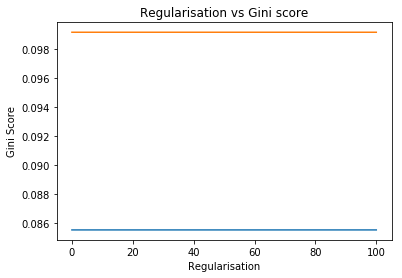

In [ ]:
reg=[0.001,0.01,1,10,100]
train_scores = []
test_scores = []
for i in tqdm(reg):
    clf = LogisticRegression(class_weight='balanced', random_state=42,C=i,n_jobs=-1,verbose=0)
    clf.fit(X_imp_train,y_train)
    train_pre=clf.predict_proba(X_imp_train)
    test_pre=clf.predict_proba(X_imp_test)
    train_sc = gini_roc(y_train,train_pre[:, 1])
    test_sc = gini_roc(y_test,test_pre[:, 1])
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Regularisation = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(reg,train_scores,label='Train Score')
plt.plot(reg,test_scores,label='Test Score')
plt.xlabel('Regularisation')
plt.ylabel('Gini Score')
plt.title('Regularisation vs Gini score')

In [ ]:
bestreg=0.001
clf_logreg = LogisticRegression(class_weight='balanced', random_state=42,C=bestreg,n_jobs=-1,verbose=0)
clf_logreg.fit(X_imp_train,y_train)
print("The Gini score for Train data is",gini_roc(y_train,clf_logreg.predict_proba(X_imp_train)[:,1]))
print("The Gini score for Test data is",gini_roc(y_test,clf_logreg.predict_proba(X_imp_test)[:,1]))


The Gini score for Train data is 0.08551825944011804
The Gini score for Test data is 0.09916272007241966


#### Kaggle Score for Logistic Regression

<img src="kaggle_test/logistic_regression.png">

### Logistic Regression using SGD Classifier

In [ ]:
reg=[0.001,0.01,1,10,100]
pen=['l1','l2','elasticnet']
train_scores = [];regu=[]
test_scores = [];pena=[]
for i in tqdm(reg):
    for j in pen:
        clf = SGDClassifier(loss='log',penalty=j,random_state=42,alpha=i,n_jobs=-1)
        regu.append(i)
        pena.append(j)
        clf.fit(X_imp_train,y_train)
        train_pre=clf.predict_proba(X_imp_train)
        test_pre=clf.predict_proba(X_imp_test)
        train_sc = gini_roc(y_train,train_pre[:, 1])
        test_sc = gini_roc(y_test,test_pre[:, 1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('Regularisation = ',i,'Penalty=',j,'Train Score',train_sc,'test Score',test_sc)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Regularisation =  0.001 Penalty= l1 Train Score 0.04516940823539861 test Score 0.03840551637082901
Regularisation =  0.001 Penalty= l2 Train Score -0.00021786083554387048 test Score 0.0014114041471919858


 20%|████████████████▌                                                                  | 1/5 [08:04<32:16, 484.03s/it]

Regularisation =  0.001 Penalty= elasticnet Train Score 0.18851958294642612 test Score 0.1893827619938917
Regularisation =  0.01 Penalty= l1 Train Score 0.00037681036198122797 test Score 0.0017983990944099304
Regularisation =  0.01 Penalty= l2 Train Score 0.0005446591611530938 test Score -0.00039681693295945397


 40%|█████████████████████████████████▏                                                 | 2/5 [16:15<24:25, 488.55s/it]

Regularisation =  0.01 Penalty= elasticnet Train Score 0.0006350971429949226 test Score 0.002375103467309403
Regularisation =  1 Penalty= l1 Train Score -2.6024249395462107e-06 test Score -5.283708740866366e-06
Regularisation =  1 Penalty= l2 Train Score 0.003313238235139737 test Score 0.006939236616595457


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [29:36<21:02, 631.07s/it]

Regularisation =  1 Penalty= elasticnet Train Score 0.0023063101618796544 test Score 0.005043194820831154
Regularisation =  10 Penalty= l1 Train Score -2.6024249395462107e-06 test Score -5.283708740866366e-06
Regularisation =  10 Penalty= l2 Train Score 0.0032869944760796077 test Score 0.006795763886190631


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [41:16<10:58, 658.30s/it]

Regularisation =  10 Penalty= elasticnet Train Score 0.0023063101618796544 test Score 0.005043194820831154
Regularisation =  100 Penalty= l1 Train Score -2.6024249395462107e-06 test Score -5.283708740866366e-06
Regularisation =  100 Penalty= l2 Train Score 0.002560476929114097 test Score 0.00549685572131553


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [49:52<00:00, 598.53s/it]

Regularisation =  100 Penalty= elasticnet Train Score 0.0023063101618796544 test Score 0.005043194820831154


In [ ]:
data={'Regularisation':regu,'Penalty':pena,'train_score':train_scores,'test_score':test_scores}
result=pd.DataFrame(data)
result

,Regularisation,Penalty,train_score,test_score
0,0.001,l1,0.045169,0.038406
1,0.001,l2,-0.000218,0.001411
2,0.001,elasticnet,0.188520,0.189383
3,0.010,l1,0.000377,0.001798
4,0.010,l2,0.000545,-0.000397
5,0.010,elasticnet,0.000635,0.002375
6,1.000,l1,-0.000003,-0.000005
7,1.000,l2,0.003313,0.006939
8,1.000,elasticnet,0.002306,0.005043
9,10.000,l1,-0.000003,-0.000005


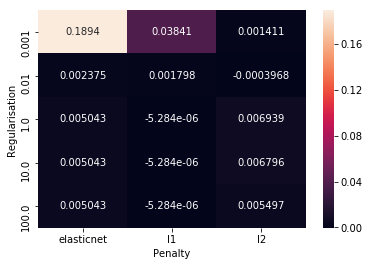

In [ ]:
max_scores = result.groupby(['Regularisation', 'Penalty']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
best_alpha=0.001
bestreg='elasticnet'

clf =SGDClassifier(loss='log',penalty=bestreg,random_state=42,alpha=best_alpha,n_jobs=-1)
clf.fit(X_imp_train,y_train)
print("The Gini score for Train data is",gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1]))
print("The Gini score for Test data is",gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1]))


The Gini score for Train data is 0.18851958294642612
The Gini score for Test data is 0.1893827619938917


#### Kaggle Score for Logistic Regression with SGD

<img src="kaggle_test/logreg_withsgd.png">

### Decision Tree

In [ ]:
min_samples_split = [2,4,6]
max_depth=[3,5,7,10]
train_scores = [];spl=[]
test_scores = [];depth=[]
for i in tqdm(min_samples_split):
    for j in max_depth:
        clf = DecisionTreeClassifier(class_weight='balanced',max_depth=j,min_samples_split=i,random_state=42)
        spl.append(i)
        depth.append(j)
        clf.fit(X_imp_train,y_train)
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('min_samples_split = ',i,"max_depth=",j,'Train Score',train_sc,'test Score',test_sc)


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

min_samples_split =  2 max_depth= 3 Train Score 0.1780178730086619 test Score 0.17443762834208054
min_samples_split =  2 max_depth= 5 Train Score 0.21910876195305673 test Score 0.20850255104343995
min_samples_split =  2 max_depth= 7 Train Score 0.2636942408199119 test Score 0.20417001172702132


 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.32s/it]

min_samples_split =  2 max_depth= 10 Train Score 0.36785072050811185 test Score 0.1537926593821941
min_samples_split =  4 max_depth= 3 Train Score 0.1780178730086619 test Score 0.17443762834208054
min_samples_split =  4 max_depth= 5 Train Score 0.21910876195305673 test Score 0.20850255104343995
min_samples_split =  4 max_depth= 7 Train Score 0.2636942408199119 test Score 0.20417001172702132


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:48, 48.46s/it]

min_samples_split =  4 max_depth= 10 Train Score 0.36781440275942456 test Score 0.15452942123464108
min_samples_split =  6 max_depth= 3 Train Score 0.1780178730086619 test Score 0.17443762834208054
min_samples_split =  6 max_depth= 5 Train Score 0.21910876195305673 test Score 0.20850255104343995
min_samples_split =  6 max_depth= 7 Train Score 0.2636942408199119 test Score 0.20417001172702132


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.82s/it]

min_samples_split =  6 max_depth= 10 Train Score 0.3677625112834526 test Score 0.15396743065102192


In [ ]:
data={'Min.samples split':spl,'Depth':depth,'train_score':train_scores,'test_score':test_scores}
result=pd.DataFrame(data)
result

,Min.samples split,Depth,train_score,test_score
0,2,3,0.178018,0.174438
1,2,5,0.219109,0.208503
2,2,7,0.263694,0.204170
3,2,10,0.367851,0.153793
4,4,3,0.178018,0.174438
5,4,5,0.219109,0.208503
6,4,7,0.263694,0.204170
7,4,10,0.367814,0.154529
8,6,3,0.178018,0.174438
9,6,5,0.219109,0.208503


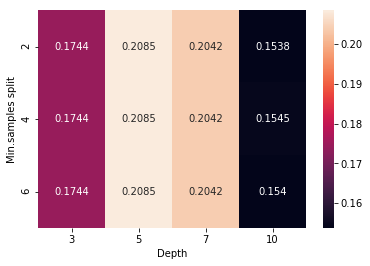

In [ ]:
# Heatmap between scores,depth and estimators

max_scores = result.groupby(['Min.samples split', 'Depth']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
best_depth=5
best_min_sample=2

clf = DecisionTreeClassifier(class_weight='balanced',max_depth=best_depth,min_samples_split=best_min_sample,random_state=42)
clf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])

print("The train gini score is ",train_sc, "\n The test gini score is ",test_sc)

The train gini score is  0.21910876195305673 
 The test gini score is  0.20850255104343995


#### Kaggle Score for Decision Tree

<img src="kaggle_test/Decision tree.png">

### Random Forest

In [ ]:
estimators = [50,100,250,450]
max_depth=[5,7,10]
train_scores = [];Est=[]
test_scores = [];depth=[]
for i in tqdm(estimators):
    for j in max_depth:
        clf = RandomForestClassifier(class_weight='balanced',max_depth=j,max_features='auto',n_estimators=i,n_jobs=-1,random_state=42)
        Est.append(i)
        depth.append(j)
        clf.fit(X_imp_train,y_train)
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('Estimators = ',i,"max_depth=",j,'Train Score',train_sc,'test Score',test_sc)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Estimators =  50 max_depth= 5 Train Score 0.2577470484658424 test Score 0.24962224268646382
Estimators =  50 max_depth= 7 Train Score 0.30646092759883814 test Score 0.2555978678110382


 25%|█████████████████████                                                               | 1/4 [01:33<04:41, 93.87s/it]

Estimators =  50 max_depth= 10 Train Score 0.45452751471688524 test Score 0.24830670844157643
Estimators =  100 max_depth= 5 Train Score 0.2597769696402352 test Score 0.2504970215946387
Estimators =  100 max_depth= 7 Train Score 0.3074268789829673 test Score 0.25661327130992895


 50%|█████████████████████████████████████████▌                                         | 2/4 [04:01<04:11, 125.62s/it]

Estimators =  100 max_depth= 10 Train Score 0.46297016760079446 test Score 0.25075613957194975
Estimators =  250 max_depth= 5 Train Score 0.2599552748700156 test Score 0.2501123064876638
Estimators =  250 max_depth= 7 Train Score 0.30742062492702393 test Score 0.2580158727201254


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [09:50<03:47, 227.73s/it]

Estimators =  250 max_depth= 10 Train Score 0.46679323601093037 test Score 0.25244821353035984
Estimators =  450 max_depth= 5 Train Score 0.2608301838150209 test Score 0.25142370543152115
Estimators =  450 max_depth= 7 Train Score 0.3074680655133111 test Score 0.25715608732264617


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [20:21<00:00, 305.30s/it]

Estimators =  450 max_depth= 10 Train Score 0.46726600110172534 test Score 0.25316139243192026


In [ ]:
data={'Estimators':Est,'Depth':depth,'train_score':train_scores,'test_score':test_scores}
result=pd.DataFrame(data)
result

,Estimators,Depth,train_score,test_score
0,50,5,0.257747,0.249622
1,50,7,0.306461,0.255598
2,50,10,0.454528,0.248307
3,100,5,0.259777,0.250497
4,100,7,0.307427,0.256613
5,100,10,0.462970,0.250756
6,250,5,0.259955,0.250112
7,250,7,0.307421,0.258016
8,250,10,0.466793,0.252448
9,450,5,0.260830,0.251424


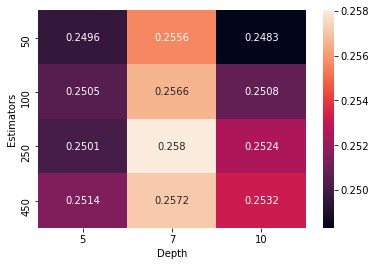

In [ ]:
# Heatmap between scores,depth and estimators

max_scores = result.groupby(['Estimators', 'Depth']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
best_depth=7
best_estimator=250

clf = RandomForestClassifier(class_weight='balanced',max_depth=best_depth,max_features='auto',
                             n_estimators=best_estimator,n_jobs=-1,random_state=42)
clf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])

print("The train gini score is ",train_sc, "\n The test gini score is ",test_sc)

The train gini score is  0.30742062492702393 
 The test gini score is  0.2580158727201254


#### Kaggle Score for Random Forest

<img src="kaggle_test/random forest.png">

### GBDT 

In [ ]:
scale=np.sqrt(y_train.eq(0).sum()/y_train.eq(1).sum())
scale

5.141660248075436

In [ ]:
max_depth= [1,2,5,7];n_estimators=[100,200,500]
train_scores = [];Est=[]
test_scores = [];depth=[]


for i in tqdm(n_estimators):
    for j in max_depth:
        Est.append(i)
        depth.append(j)
        clf = XGBClassifier(class_weight='balanced',max_depth=j,n_estimators=i,n_jobs=-1,random_state=42,scale_pos_weight=scale)
        clf.fit(X_imp_train,y_train)
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('Estimators = ',i,"max_depth=",j,'Train Score',train_sc,'test Score',test_sc)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Estimators =  100 max_depth= 1 Train Score 0.25220049777504805 test Score 0.26104614721468433
Estimators =  100 max_depth= 2 Train Score 0.2804311430146027 test Score 0.275869613121569
Estimators =  100 max_depth= 5 Train Score 0.4028097056241202 test Score 0.28002637446728484


 33%|███████████████████████████▋                                                       | 1/3 [03:41<07:22, 221.44s/it]

Estimators =  100 max_depth= 7 Train Score 0.5789321458018035 test Score 0.2667406456743302
Estimators =  200 max_depth= 1 Train Score 0.2655846675414091 test Score 0.2705253384208621
Estimators =  200 max_depth= 2 Train Score 0.2969013755224892 test Score 0.2787756411202109
Estimators =  200 max_depth= 5 Train Score 0.4806227756680366 test Score 0.2719443644230852


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:04<05:16, 316.65s/it]

Estimators =  200 max_depth= 7 Train Score 0.7139231088744866 test Score 0.250984978259583
Estimators =  500 max_depth= 1 Train Score 0.2777461826201757 test Score 0.27371449984572105
Estimators =  500 max_depth= 2 Train Score 0.32535032401878006 test Score 0.27954872468773884
Estimators =  500 max_depth= 5 Train Score 0.6446855824357582 test Score 0.2516865107127668


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [25:40<00:00, 513.34s/it]

Estimators =  500 max_depth= 7 Train Score 0.896148471159186 test Score 0.21998485830337877


In [ ]:
data_xgb={'Estimators':Est,'Depth':depth,'train_score':train_scores,'test_score':test_scores}
result1=pd.DataFrame(data_xgb)
result1

,Estimators,Depth,train_score,test_score
0,100,1,0.252200,0.261046
1,100,2,0.280431,0.275870
2,100,5,0.402810,0.280026
3,100,7,0.578932,0.266741
4,200,1,0.265585,0.270525
5,200,2,0.296901,0.278776
6,200,5,0.480623,0.271944
7,200,7,0.713923,0.250985
8,500,1,0.277746,0.273714
9,500,2,0.325350,0.279549


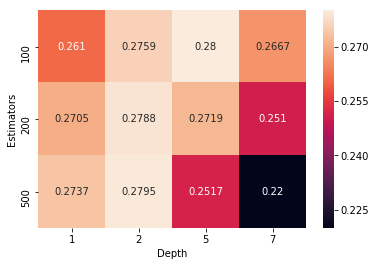

In [ ]:
# Heatmap between scores,depth and estimators

max_scores = result1.groupby(['Estimators', 'Depth']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
Estimators =  200;max_depth= 2
clf = XGBClassifier(class_weight='balanced',max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=scale)
clf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])

print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.2969013755224892 
The test gini score is  0.2787756411202109


#### Kaggle Score for GBDT

<img src="kaggle_test/gbdt.png">

### GBDT using Light GBM 

In [ ]:

max_depth= [1,2,5];n_estimators=[100,200,500,750]
train_scores = [];Est=[]
test_scores = [];depth=[]


for i in tqdm(n_estimators):
    for j in max_depth:
        Est.append(i)
        depth.append(j)
        clf = LGBMClassifier(class_weight='balanced',max_depth=j,n_estimators=i,n_jobs=-1,random_state=42)
        clf.fit(X_imp_train,y_train)
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('Estimators = ',i,"max_depth=",j,'Train Score',train_sc,'test Score',test_sc)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Estimators =  100 max_depth= 1 Train Score 0.25288905232511416 test Score 0.260962577674144
Estimators =  100 max_depth= 2 Train Score 0.2811363847753183 test Score 0.27542216070801406


 25%|█████████████████████                                                               | 1/4 [00:19<00:59, 19.82s/it]

Estimators =  100 max_depth= 5 Train Score 0.40978856368057603 test Score 0.26822001843520593
Estimators =  200 max_depth= 1 Train Score 0.2653142230403629 test Score 0.2699320005874386
Estimators =  200 max_depth= 2 Train Score 0.297083636581414 test Score 0.27877066370272985


 50%|██████████████████████████████████████████                                          | 2/4 [00:44<00:45, 22.71s/it]

Estimators =  200 max_depth= 5 Train Score 0.4928835431338583 test Score 0.2552395719858189
Estimators =  500 max_depth= 1 Train Score 0.2773362776848609 test Score 0.27321751829036156
Estimators =  500 max_depth= 2 Train Score 0.32609262764087976 test Score 0.27780452733745764


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:26<00:31, 31.28s/it]

Estimators =  500 max_depth= 5 Train Score 0.6755159601300944 test Score 0.2291017903492436
Estimators =  750 max_depth= 1 Train Score 0.2817727918144852 test Score 0.2735619992726963
Estimators =  750 max_depth= 2 Train Score 0.3443733577793333 test Score 0.2758894379156027


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:20<00:00, 35.12s/it]

Estimators =  750 max_depth= 5 Train Score 0.7729358557962376 test Score 0.21129008713158992


In [ ]:
data_xgb={'Estimators':Est,'Depth':depth,'train_score':train_scores,'test_score':test_scores}
result1=pd.DataFrame(data_xgb)
result1

,Estimators,Depth,train_score,test_score
0,100,1,0.252889,0.260963
1,100,2,0.281136,0.275422
2,100,5,0.409789,0.268220
3,200,1,0.265314,0.269932
4,200,2,0.297084,0.278771
5,200,5,0.492884,0.255240
6,500,1,0.277336,0.273218
7,500,2,0.326093,0.277805
8,500,5,0.675516,0.229102
9,750,1,0.281773,0.273562


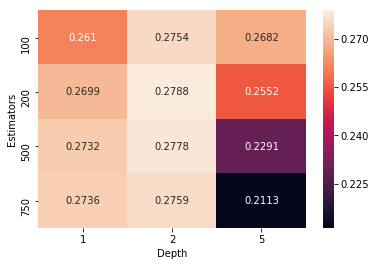

In [ ]:
# Heatmap between scores,depth and estimators

max_scores = result1.groupby(['Estimators', 'Depth']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
best_depth=2;best_estimator=200

clf = LGBMClassifier(class_weight='balanced',max_depth=best_depth,n_estimators=best_estimator,random_state=42)
clf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])

print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.297083636581414 
The test gini score is  0.27877066370272985


### Ada Boost Classifier

In [ ]:


learning_rate= [0.001,0.1,1,10];n_estimators=[100,200,500]
train_scores = [];lr=[]
test_scores = [];depth=[]


for i in tqdm(n_estimators):
    for j in learning_rate:
        lr.append(i)
        depth.append(j)
        clf = AdaBoostClassifier(learning_rate=j,n_estimators=i,random_state=42)
        clf.fit(X_imp_train,y_train)
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        test_scores.append(test_sc)
        train_scores.append(train_sc)
        print('Estimators = ',i,"learning_rate=",j,'Train Score',train_sc,'test Score',test_sc)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Estimators =  100 learning_rate= 0.001 Train Score 0.12339146023557479 test Score 0.12759676137777687
Estimators =  100 learning_rate= 0.1 Train Score 0.25310360207401117 test Score 0.26111758762134407
Estimators =  100 learning_rate= 1 Train Score 0.28316227313104325 test Score 0.2637215932486925


 33%|███████████████████████████▎                                                      | 1/3 [25:04<50:08, 1504.42s/it]

Estimators =  100 learning_rate= 10 Train Score 0.08480787764395936 test Score 0.09327066006007767
Estimators =  200 learning_rate= 0.001 Train Score 0.13324715627400363 test Score 0.1394523749488088
Estimators =  200 learning_rate= 0.1 Train Score 0.2656737215022822 test Score 0.2701485123434628
Estimators =  200 learning_rate= 1 Train Score 0.2946985715083603 test Score 0.26102324843728586


 67%|██████████████████████████████████████████████████████▋                           | 2/3 [52:18<26:20, 1580.86s/it]

Estimators =  200 learning_rate= 10 Train Score 0.08480787764395936 test Score 0.09327066006007767
Estimators =  500 learning_rate= 0.001 Train Score 0.18182704266126204 test Score 0.1889956371496575
Estimators =  500 learning_rate= 0.1 Train Score 0.27841419135210166 test Score 0.27254871619498333
Estimators =  500 learning_rate= 1 Train Score 0.31187623138420273 test Score 0.2573805449381903
Estimators =  500 learning_rate= 10 Train Score 0.08480787764395936 test Score 0.09327066006007767


100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:05:40<00:00, 2513.45s/it]


In [ ]:
data_ada={'Estimators':lr,'learning_rate':depth,'train_score':train_scores,'test_score':test_scores}
result1=pd.DataFrame(data_ada)
result1

,Estimators,learning_rate,train_score,test_score
0,100,0.001,0.123391,0.127597
1,100,0.100,0.253104,0.261118
2,100,1.000,0.283162,0.263722
3,100,10.000,0.084808,0.093271
4,200,0.001,0.133247,0.139452
5,200,0.100,0.265674,0.270149
6,200,1.000,0.294699,0.261023
7,200,10.000,0.084808,0.093271
8,500,0.001,0.181827,0.188996
9,500,0.100,0.278414,0.272549


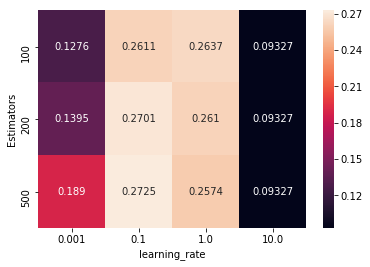

In [ ]:
# Heatmap between scores,depth and estimators

max_scores = result1.groupby(['Estimators', 'learning_rate']).max()
max_scores = max_scores.unstack()[['test_score', 'train_score']]
sns.heatmap(max_scores.test_score, annot=True, fmt='.4g');


In [ ]:
best_lr=0.1;best_estimator=500

clf = AdaBoostClassifier(learning_rate=best_lr,n_estimators=best_estimator,random_state=42)
clf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])

print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.27841419135210166 
The test gini score is  0.27254871619498333


### Stacking Models - Random forest+GBDT(Xgboost)

In [ ]:
reg=[0.001,0.01,1,10,100]

# Initializing Random Forest classifier
classifier1 = RandomForestClassifier(class_weight='balanced',max_depth=7,max_features='auto',
                             n_estimators=250,n_jobs=-1,random_state=42)

# Initializing GBDT using Xgboost  classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)

for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    
    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

 20%|████████████████▌                                                                  | 1/5 [06:42<26:51, 402.87s/it]

The train gini score is  0.30859495579735596 
The test gini score is  0.2707678923144645 Reg 0.001


 40%|█████████████████████████████████▏                                                 | 2/5 [13:18<19:56, 398.82s/it]

The train gini score is  0.30876478465964485 
The test gini score is  0.26622296990059047 Reg 0.01


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [19:54<13:14, 397.25s/it]

The train gini score is  0.306589370474204 
The test gini score is  0.2549710571402737 Reg 1


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [26:42<06:41, 401.71s/it]

The train gini score is  0.3065036707499198 
The test gini score is  0.2546822621230871 Reg 10


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [34:02<00:00, 408.46s/it]

The train gini score is  0.3064932456522569 
The test gini score is  0.2546501273726225 Reg 100


Best_Regularisation =0.001 

Best_Train Score=0.308

Best_Test Score= 0.270

In [ ]:
Best_Reg=0.001

# Initializing Random Forest classifier
classifier1 = RandomForestClassifier(class_weight='balanced',max_depth=7,max_features='auto',
                             n_estimators=250,n_jobs=-1,random_state=42)

# Initializing GBDT using Xgboost  classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)


meta=LogisticRegression(random_state=42,C=Best_Reg,n_jobs=-1)

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],
                        use_probas = True,
                        cv = 5,
                        meta_classifier = meta)
 
sclf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,sclf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,sclf.predict_proba(X_imp_test)[:,1])
print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)    

The train gini score is  0.3072075909765124 
The test gini score is  0.2748538915225991


### Stacking Models - GBDT(Light bgm) + GBDT(Xgboost)

In [ ]:
reg=[0.001,0.01,1,10,100]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (Using Xgboost)  classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)


for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    
    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

 20%|████████████████▌                                                                  | 1/5 [03:23<13:32, 203.06s/it]

The train gini score is  0.2974786128900324 
The test gini score is  0.27916227958868567 Reg 0.001


 40%|█████████████████████████████████▏                                                 | 2/5 [06:40<09:59, 199.80s/it]

The train gini score is  0.2974633327972085 
The test gini score is  0.27914676575187447 Reg 0.01


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [09:59<06:38, 199.42s/it]

The train gini score is  0.29741591799345946 
The test gini score is  0.2790998685007484 Reg 1


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [13:16<03:18, 198.53s/it]

The train gini score is  0.29741533681207977 
The test gini score is  0.2790991068318811 Reg 10


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:34<00:00, 198.95s/it]

The train gini score is  0.2974146940390816 
The test gini score is  0.27909827431009626 Reg 100


Best_Regularisation =0.001 

Best_Train Score=0.297

Best_Test Score= 0.279

In [ ]:
Best_reg=0.001


# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (Using Xgboost)  classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)


meta=LogisticRegression(random_state=42,C=Best_reg,n_jobs=-1)

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],
                        use_probas = True,
                        cv = 5,
                        meta_classifier = meta)
                        
sclf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,sclf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,sclf.predict_proba(X_imp_test)[:,1])
print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.29743244424229154 
The test gini score is  0.27911623257257423


### Feature Importance using GBDT(Xgboost) 

#### Stacking-GBDT(Xgboost)+GBDT(Light GBM) + Logistic Reg(Meta)-Top 100 features

In [ ]:
#Feature selection using Gradient Boost Classifier


base=XGBClassifier(n_estimators=200,n_jobs=-1,random_state = 42)
Xgmodel=SelectFromModel(base,max_features=100)
Xgmodel.fit(X_imp_train,y_train)

#XGBoost feature importance

imp_feature=X_imp_train.columns[Xgmodel.get_support()]
print(imp_feature)

X_feature_imp_train=X_imp_train[imp_feature]
X_feature_imp_test=X_imp_test[imp_feature]

reg=[0.0001,0.001,0.01,1,10]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (using Lightbgm) classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)


for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    #meta=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=i,n_jobs=-1)

    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_feature_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

Index(['Unnamed__0', 'ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_08', 'ps_calc_11', 'ps_calc_12',
       'ps_calc_13', 'ps_calc_14', 'ps_ind_02_cat_1__0', 'ps_ind_02_cat_2__0',
       'ps_ind_02_cat_4__0', 'ps_ind_04_cat_0__0', 'ps_ind_05_cat_0__0',
       'ps_ind_05_cat_2__0', 'ps_ind_05_cat_3__0', 'ps_ind_05_cat_6__0',
       'ps_ind_06_bin_0__0', 'ps_ind_07_bin_0__0', 'ps_ind_08_bin_0__0',
       'ps_ind_09_bin_0__0', 'ps_ind_12_bin_0__0', 'ps_ind_16_bin_0__0',
       'ps_ind_17_bin_0__0', 'ps_ind_18_bin_0__0', 'ps_car_01_cat_1__0',
       'ps_car_01_cat_5__0', 'ps_car_01_cat_6__0', 'ps_car_01_cat_7__0',
       'ps_car_01_cat_9__0', 'ps_car_01_cat_10__0', 'ps_car_01_cat_11__0',
       'ps_car_02_cat_0__0', 'ps_car_03_cat___1__0', 'ps_car_03_cat_0__0',
       'ps_car_03_cat_1__0', 'ps_car

 20%|████████████████▊                                                                   | 1/5 [01:37<06:28, 97.15s/it]

The train gini score is  0.29640994799215337 
The test gini score is  0.2811855481312251 Reg 0.0001


 40%|█████████████████████████████████▌                                                  | 2/5 [03:14<04:51, 97.16s/it]

The train gini score is  0.29641322130021996 
The test gini score is  0.2811870640884475 Reg 0.001


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:56<03:18, 99.29s/it]

The train gini score is  0.2964002115031126 
The test gini score is  0.2811808186989564 Reg 0.01


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [06:40<01:41, 101.10s/it]

The train gini score is  0.2963621693681444 
The test gini score is  0.2811584601750572 Reg 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:17<00:00, 99.41s/it]

The train gini score is  0.2963617554151716 
The test gini score is  0.28115817971559065 Reg 10


Best Regularisation: 0.001
    
Train Gini Score: 0.296
    
Test Gini Score: 0.281

#### GBDT(Xgboost)+GBDT(Light GBM) + Logistic Reg(Meta)-Top 75 features

In [ ]:
#Feature selection using Gradient Boost Classifier


base=XGBClassifier(n_estimators=200,n_jobs=-1,random_state = 42)
Xgmodel=SelectFromModel(base,max_features=75)
Xgmodel.fit(X_imp_train,y_train)

#XGBoost feature importance

imp_feature=X_imp_train.columns[Xgmodel.get_support()]
print(imp_feature)

X_feature_imp_train=X_imp_train[imp_feature]
X_feature_imp_test=X_imp_test[imp_feature]

reg=[0.0001,0.001,0.01,1,10]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (using Lightbgm) classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)

#classifier3=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=0.001,n_jobs=-1)

#classifier3=lgb(num_threads=4,seed=42)

for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    #meta=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=i,n_jobs=-1)

    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_feature_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_08', 'ps_calc_12', 'ps_ind_02_cat_1__0', 'ps_ind_02_cat_2__0',
       'ps_ind_04_cat_0__0', 'ps_ind_05_cat_0__0', 'ps_ind_05_cat_2__0',
       'ps_ind_05_cat_3__0', 'ps_ind_05_cat_6__0', 'ps_ind_06_bin_0__0',
       'ps_ind_07_bin_0__0', 'ps_ind_08_bin_0__0', 'ps_ind_09_bin_0__0',
       'ps_ind_12_bin_0__0', 'ps_ind_16_bin_0__0', 'ps_ind_17_bin_0__0',
       'ps_car_01_cat_6__0', 'ps_car_01_cat_7__0', 'ps_car_01_cat_9__0',
       'ps_car_01_cat_10__0', 'ps_car_02_cat_0__0', 'ps_car_03_cat___1__0',
       'ps_car_03_cat_0__0', 'ps_car_03_cat_1__0', 'ps_car_04_cat_0__0',
       'ps_car_04_cat_2__0', 'ps_car_05_cat___1__0', 'ps_car_06_cat_9__0',
       'ps_car_06_cat_10__0', 'ps_car_07_cat___1__0', 'ps_car_07_cat_1__0',
       'ps_car_08_cat_0__0', 'ps_car

 20%|████████████████▊                                                                   | 1/5 [01:24<05:36, 84.05s/it]

The train gini score is  0.29555816365623455 
The test gini score is  0.2809949353308405 Reg 0.0001


 40%|█████████████████████████████████▌                                                  | 2/5 [02:50<04:16, 85.40s/it]

The train gini score is  0.29556414592125524 
The test gini score is  0.28100242064639436 Reg 0.001


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:14<02:49, 84.77s/it]

The train gini score is  0.2955590757135198 
The test gini score is  0.28099587413200244 Reg 0.01


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:36<01:23, 83.79s/it]

The train gini score is  0.2952667343177189 
The test gini score is  0.28068298912273604 Reg 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:59<00:00, 83.82s/it]

The train gini score is  0.2952263796323198 
The test gini score is  0.28064025005222826 Reg 10


Best Regularisation: 0.001
    
Train Gini Score: 0.295
    
Test Gini Score: 0.281

#### GBDT(Xgboost)+GBDT(Light GBM) + Logistic Reg(Meta)-Top 50 features

In [ ]:
#Feature selection using Gradient Boost Classifier

base=XGBClassifier(n_estimators=200,n_jobs=-1,random_state = 42)
Xgmodel=SelectFromModel(base,max_features=50)
Xgmodel.fit(X_imp_train,y_train)

#XGBoost feature importance

imp_feature_50=X_imp_train.columns[Xgmodel.get_support()]
print(imp_feature_50)

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_11', 'ps_car_13', 'ps_car_15',
       'ps_ind_02_cat_1__0', 'ps_ind_02_cat_2__0', 'ps_ind_04_cat_0__0',
       'ps_ind_05_cat_0__0', 'ps_ind_05_cat_2__0', 'ps_ind_05_cat_6__0',
       'ps_ind_06_bin_0__0', 'ps_ind_07_bin_0__0', 'ps_ind_08_bin_0__0',
       'ps_ind_09_bin_0__0', 'ps_ind_12_bin_0__0', 'ps_ind_16_bin_0__0',
       'ps_ind_17_bin_0__0', 'ps_car_01_cat_6__0', 'ps_car_01_cat_7__0',
       'ps_car_01_cat_9__0', 'ps_car_02_cat_0__0', 'ps_car_03_cat___1__0',
       'ps_car_03_cat_1__0', 'ps_car_04_cat_0__0', 'ps_car_04_cat_2__0',
       'ps_car_06_cat_9__0', 'ps_car_06_cat_10__0', 'ps_car_07_cat___1__0',
       'ps_car_07_cat_1__0', 'ps_car_09_cat_0__0', 'ps_car_09_cat_1__0',
       'ps_car_11_cat_3__0', 'ps_car_11_cat_25__0', 'ps_car_11_cat_40__0',
       'ps_car_11_cat_41__0', 'ps_car_11_cat_61__0', 'ps_car_11_cat_75__0',
       'ps_car_11_cat_77__0', 'ps_car_11_cat_90__0', 'ps

In [ ]:
X_feature_imp_train=X_imp_train[imp_feature]
X_feature_imp_test=X_imp_test[imp_feature]


In [ ]:
reg=[0.0001,0.001,0.01,1,10]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (using Lightbgm) classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)


for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    #meta=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=i,n_jobs=-1)

    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_feature_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

 20%|████████████████▊                                                                   | 1/5 [01:09<04:36, 69.24s/it]

The train gini score is  0.29398001360385195 
The test gini score is  0.2824539430441837 Reg 0.0001


 40%|█████████████████████████████████▌                                                  | 2/5 [02:11<03:15, 65.14s/it]

The train gini score is  0.2939833728537118 
The test gini score is  0.2824535149744716 Reg 0.001


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:11<02:05, 62.77s/it]

The train gini score is  0.29398074983855094 
The test gini score is  0.28245382495598714 Reg 0.01


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:13<01:02, 62.34s/it]

The train gini score is  0.2938154916473219 
The test gini score is  0.28242413905949704 Reg 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:15<00:00, 63.02s/it]

The train gini score is  0.2937924402678056 
The test gini score is  0.28241748036131864 Reg 10


Best Regularisation: 0.001
    
Train Gini Score: 0.293
    
Test Gini Score: 0.282

#### GBDT(Xgboost)+GBDT(Light GBM) + Logistic Reg(Meta)-Top 25 features

In [ ]:
#Feature selection using Gradient Boost Classifier


base=XGBClassifier(n_estimators=200,n_jobs=-1,random_state = 42)
Xgmodel=SelectFromModel(base,max_features=25)
Xgmodel.fit(X_imp_train,y_train)

#XGBoost feature importance

imp_feature=X_imp_train.columns[Xgmodel.get_support()]
print(imp_feature)

X_feature_imp_train=X_imp_train[imp_feature]
X_feature_imp_test=X_imp_test[imp_feature]

reg=[0.0001,0.001,0.01,1,10]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = LGBMClassifier(class_weight='balanced',random_state=42,n_estimators=200,max_depth=2)

# Initializing GBDT (using Lightbgm) classifier
classifier2 = XGBClassifier(max_depth=2,n_estimators=200,n_jobs=-1,random_state=42,scale_pos_weight=5.141660248075436)

#classifier3=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=0.001,n_jobs=-1)

#classifier3=lgb(num_threads=4,seed=42)

for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    #meta=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,alpha=i,n_jobs=-1)

    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42)
                            
    sclf.fit(X_feature_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Index(['ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_11', 'ps_car_13', 'ps_ind_02_cat_1__0', 'ps_ind_02_cat_2__0',
       'ps_ind_05_cat_0__0', 'ps_ind_05_cat_6__0', 'ps_ind_06_bin_0__0',
       'ps_ind_07_bin_0__0', 'ps_ind_08_bin_0__0', 'ps_ind_16_bin_0__0',
       'ps_ind_17_bin_0__0', 'ps_car_01_cat_6__0', 'ps_car_01_cat_7__0',
       'ps_car_01_cat_9__0', 'ps_car_03_cat___1__0', 'ps_car_03_cat_1__0',
       'ps_car_04_cat_0__0', 'ps_car_07_cat___1__0', 'ps_car_07_cat_1__0',
       'ps_car_09_cat_1__0'],
      dtype='object')


 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.24s/it]

The train gini score is  0.2864807901618138 
The test gini score is  0.2778385352619388 Reg 0.0001


 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:49, 36.41s/it]

The train gini score is  0.28648181036252285 
The test gini score is  0.2778375019902197 Reg 0.001


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:11, 35.75s/it]

The train gini score is  0.28648300638581814 
The test gini score is  0.2778361469281654 Reg 0.01


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:22<00:35, 35.47s/it]

The train gini score is  0.28646879411978077 
The test gini score is  0.2778520076490536 Reg 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.73s/it]

The train gini score is  0.28646591327923887 
The test gini score is  0.27785433693872896 Reg 10


Best Regularisation: 0.001
    
Train Gini Score: 0.286
    
Test Gini Score: 0.277

The Stacked model with top 50 features performs well when compared to other models in the segment. So I further tuned it to see if the Gini Score can be improved.

### Further Tuning the GBDT(Xgboost)+GBDT(Light GBM) + Logistic Reg(Meta)-Top 50 features

In [ ]:
imp_feature_50=X_imp_train[['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_11', 'ps_car_13', 'ps_car_15',
       'ps_ind_02_cat_1__0', 'ps_ind_02_cat_2__0', 'ps_ind_04_cat_0__0',
       'ps_ind_05_cat_0__0', 'ps_ind_05_cat_2__0', 'ps_ind_05_cat_6__0',
       'ps_ind_06_bin_0__0', 'ps_ind_07_bin_0__0', 'ps_ind_08_bin_0__0',
       'ps_ind_09_bin_0__0', 'ps_ind_12_bin_0__0', 'ps_ind_16_bin_0__0',
       'ps_ind_17_bin_0__0', 'ps_car_01_cat_6__0', 'ps_car_01_cat_7__0',
       'ps_car_01_cat_9__0', 'ps_car_02_cat_0__0', 'ps_car_03_cat___1__0',
       'ps_car_03_cat_1__0', 'ps_car_04_cat_0__0', 'ps_car_04_cat_2__0',
       'ps_car_06_cat_9__0', 'ps_car_06_cat_10__0', 'ps_car_07_cat___1__0',
       'ps_car_07_cat_1__0', 'ps_car_09_cat_0__0', 'ps_car_09_cat_1__0',
       'ps_car_11_cat_3__0', 'ps_car_11_cat_25__0', 'ps_car_11_cat_40__0',
       'ps_car_11_cat_41__0', 'ps_car_11_cat_61__0', 'ps_car_11_cat_75__0',
       'ps_car_11_cat_77__0', 'ps_car_11_cat_90__0', 'ps_car_11_cat_94__0',
       'ps_car_11_cat_101__0', 'ps_calc_18_bin_0__0', 'svd_1', 'svd_2',
       'svd_5']].columns

#### Training LightGBM GBDT

In [ ]:
X_feature_imp_train=X_imp_train[imp_feature_50]
X_feature_imp_test=X_imp_test[imp_feature_50]

colsample_bytree=[0.5,1,0.2] 
max_depth= [2,3];n_estimators=[300,500,750]
train_scores = [];Est=[]
test_scores = [];depth=[]
#min_child_weight=[50,100,125]
reg_alpha=[0.001,1,10]
reg_lambda=[0.001,1,10]
for i in tqdm(n_estimators):
    for j in max_depth:
      for k in colsample_bytree:
        for l in reg_alpha:
          for m in reg_lambda:
            Est.append(i)
            depth.append(j)
            clf = LGBMClassifier(reg_lambda=m,reg_alpha=l,class_weight='balanced',max_depth=j,n_estimators=i,n_jobs=-1,random_state=42,colsample_bytree=k,min_child_weight=125)
            clf.fit(X_feature_imp_train,y_train)
            train_sc = gini_roc(y_train,clf.predict_proba(X_feature_imp_train)[:,1])
            test_sc = gini_roc(y_test,clf.predict_proba(X_feature_imp_test)[:,1])
            test_scores.append(test_sc)
            train_scores.append(train_sc)
            print('Est = ',i,"depth=",j,'Train',train_sc,'test',test_sc,'colsample_bytree',k,'alpha',l,'lambda',m)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Est =  300 depth= 2 Train 0.2989994159529985 test 0.2850647505516488 colsample_bytree 0.5 alpha 0.001 lambda 0.001
Est =  300 depth= 2 Train 0.29907082409413177 test 0.28430347432766556 colsample_bytree 0.5 alpha 0.001 lambda 1
Est =  300 depth= 2 Train 0.2986374164058385 test 0.28494160153790804 colsample_bytree 0.5 alpha 0.001 lambda 10
Est =  300 depth= 2 Train 0.29878622551680456 test 0.28458398914812566 colsample_bytree 0.5 alpha 1 lambda 0.001
Est =  300 depth= 2 Train 0.29841801757027886 test 0.28440281085658814 colsample_bytree 0.5 alpha 1 lambda 1
Est =  300 depth= 2 Train 0.29803885276124165 test 0.28406343940290424 colsample_bytree 0.5 alpha 1 lambda 10
Est =  300 depth= 2 Train 0.2991097707664778 test 0.2857317053048034 colsample_bytree 0.5 alpha 10 lambda 0.001
Est =  300 depth= 2 Train 0.2986097486986843 test 0.28426272504326855 colsample_bytree 0.5 alpha 10 lambda 1
Est =  300 depth= 2 Train 0.29787120180724047 test 0.2851529491494902 colsample_bytree 0.5 alpha 10 lambda

 33%|███████████████████████████▋                                                       | 1/3 [06:26<12:53, 386.55s/it]

Est =  300 depth= 3 Train 0.3216268231156092 test 0.2858481830734947 colsample_bytree 0.2 alpha 10 lambda 10
Est =  500 depth= 2 Train 0.3109000924956611 test 0.2868210157775579 colsample_bytree 0.5 alpha 0.001 lambda 0.001
Est =  500 depth= 2 Train 0.3113488146534955 test 0.2868282944387679 colsample_bytree 0.5 alpha 0.001 lambda 1
Est =  500 depth= 2 Train 0.31076028131144695 test 0.2871406554316627 colsample_bytree 0.5 alpha 0.001 lambda 10
Est =  500 depth= 2 Train 0.31119593422909975 test 0.28783766141666556 colsample_bytree 0.5 alpha 1 lambda 0.001
Est =  500 depth= 2 Train 0.311033712289823 test 0.2866226807471757 colsample_bytree 0.5 alpha 1 lambda 1
Est =  500 depth= 2 Train 0.3099530017543344 test 0.28560371393695627 colsample_bytree 0.5 alpha 1 lambda 10
Est =  500 depth= 2 Train 0.3106087358495797 test 0.28774270300762717 colsample_bytree 0.5 alpha 10 lambda 0.001
Est =  500 depth= 2 Train 0.30994160945340177 test 0.2861925459676331 colsample_bytree 0.5 alpha 10 lambda 1
Es

 67%|███████████████████████████████████████████████████████▎                           | 2/3 [16:15<08:25, 505.73s/it]

Est =  500 depth= 3 Train 0.34189620088204586 test 0.2851281698175634 colsample_bytree 0.2 alpha 10 lambda 10
Est =  750 depth= 2 Train 0.32241706918826196 test 0.2869043033825289 colsample_bytree 0.5 alpha 0.001 lambda 0.001
Est =  750 depth= 2 Train 0.3230329250379267 test 0.28666966656444903 colsample_bytree 0.5 alpha 0.001 lambda 1
Est =  750 depth= 2 Train 0.32185728713614914 test 0.28704077200678046 colsample_bytree 0.5 alpha 0.001 lambda 10
Est =  750 depth= 2 Train 0.32265991151277174 test 0.28749905310795154 colsample_bytree 0.5 alpha 1 lambda 0.001
Est =  750 depth= 2 Train 0.32258465085169186 test 0.28629037170569194 colsample_bytree 0.5 alpha 1 lambda 1
Est =  750 depth= 2 Train 0.3217327918538395 test 0.2856764887402361 colsample_bytree 0.5 alpha 1 lambda 10
Est =  750 depth= 2 Train 0.32173786707484653 test 0.2865057439106202 colsample_bytree 0.5 alpha 10 lambda 0.001
Est =  750 depth= 2 Train 0.3212495107103166 test 0.28655718165290045 colsample_bytree 0.5 alpha 10 lambd

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [30:28<00:00, 609.63s/it]

Est =  750 depth= 3 Train 0.3631698532688632 test 0.282256089223202 colsample_bytree 0.2 alpha 10 lambda 10


#### Hyper Tuning Xgboost GBDT

In [ ]:
max_depth= [2,3];n_estimators=[200,300,500,750]
subsample=[0.2,0.5,1]

classifier1 = XGBClassifier(max_depth=2,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,reg_alpha=10,reg_lambda=10)

classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

meta=LogisticRegression(random_state=42,C=0.001,n_jobs=-1)

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                        meta_classifier = meta,random_state=42)

for i in tqdm(n_estimators):
    for j in subsample:
        for k in max_depth:

            classifier1 = XGBClassifier(max_depth=k,n_estimators=i,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=j)

            sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                                    meta_classifier = meta,random_state=42)

            sclf.fit(X_feature_imp_train,y_train)
            train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
            test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
            print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i,j,k)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

The train gini score is  0.31774016171715647 
The test gini score is  0.28721646805379697 Reg 200 0.2 2
The train gini score is  0.32487207369300397 
The test gini score is  0.2865220253207088 Reg 200 0.2 3
The train gini score is  0.3177390813571921 
The test gini score is  0.28754094046734213 Reg 200 0.5 2
The train gini score is  0.32608235580608214 
The test gini score is  0.2876893596170764 Reg 200 0.5 3
The train gini score is  0.31772067011835237 
The test gini score is  0.28736179329278366 Reg 200 1 2


 25%|████████████████████▊                                                              | 1/4 [09:53<29:39, 593.13s/it]

The train gini score is  0.32473395699448826 
The test gini score is  0.28816686547663295 Reg 200 1 3
The train gini score is  0.319938498727514 
The test gini score is  0.28771001471874147 Reg 300 0.2 2
The train gini score is  0.3306255920969947 
The test gini score is  0.2869437787905067 Reg 300 0.2 3
The train gini score is  0.31992291712223087 
The test gini score is  0.28757202275675553 Reg 300 0.5 2
The train gini score is  0.33231862466301965 
The test gini score is  0.287361965996771 Reg 300 0.5 3
The train gini score is  0.31914737622761136 
The test gini score is  0.28750065763132104 Reg 300 1 2


 50%|█████████████████████████████████████████▌                                         | 2/4 [22:34<23:03, 691.89s/it]

The train gini score is  0.32957079265420663 
The test gini score is  0.28804016422233225 Reg 300 1 3
The train gini score is  0.3239174082568377 
The test gini score is  0.2871336040902308 Reg 500 0.2 2
The train gini score is  0.3411476313870061 
The test gini score is  0.2865809542829525 Reg 500 0.2 3
The train gini score is  0.3242096694402974 
The test gini score is  0.28721199841556055 Reg 500 0.5 2
The train gini score is  0.3447832997770466 
The test gini score is  0.287002684135111 Reg 500 0.5 3
The train gini score is  0.322150925178762 
The test gini score is  0.2874019728016328 Reg 500 1 2


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [40:47<14:35, 875.05s/it]

The train gini score is  0.3391943745896564 
The test gini score is  0.2878456862476668 Reg 500 1 3
The train gini score is  0.32779694973577556 
The test gini score is  0.2869789956428992 Reg 750 0.2 2
The train gini score is  0.3520313635194019 
The test gini score is  0.2865898286109174 Reg 750 0.2 3
The train gini score is  0.32923507965795795 
The test gini score is  0.2870267519856544 Reg 750 0.5 2
The train gini score is  0.35822977000295664 
The test gini score is  0.2863220665776247 Reg 750 0.5 3
The train gini score is  0.32606254299982385 
The test gini score is  0.2871609400316115 Reg 750 1 2


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:07:46<00:00, 1016.71s/it]

The train gini score is  0.35084981282221994 
The test gini score is  0.28717193256660045 Reg 750 1 3


#### Training other parameters of XGboost GBDT 

In [ ]:
max_depth= [2,3];n_estimators=[200,300,500]
subsample=[0.2,0.5,1]
min_child_weight=[1,2,5,10]
reg_alpha=[0.001,1,10]
reg_lambda=[0.001,1,10]
#classifier1 = XGBClassifier(max_depth=2,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,reg_alpha=10,reg_lambda=10)

#classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

meta=LogisticRegression(random_state=42,C=0.001,n_jobs=-1)

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                        meta_classifier = meta,random_state=42)

for j in tqdm(reg_alpha):
    for k in reg_lambda:

        classifier1 = XGBClassifier(max_depth=3,min_child_weight=5,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=1,reg_lambda=k,reg_alpha=j)
        classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

        sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                                meta_classifier = meta,random_state=42)

        sclf.fit(X_feature_imp_train,y_train)
        train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
        test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
        print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',j,k)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

The train gini score is  0.3245123589442376 
The test gini score is  0.28828878415897674 Reg 0.001 0.001
The train gini score is  0.32469764694475356 
The test gini score is  0.28824469297861954 Reg 0.001 1


 33%|███████████████████████████▋                                                       | 1/3 [05:22<10:45, 322.75s/it]

The train gini score is  0.324184459489397 
The test gini score is  0.2882193335384273 Reg 0.001 10
The train gini score is  0.3245707155706843 
The test gini score is  0.2881023981779749 Reg 1 0.001
The train gini score is  0.3246175019250672 
The test gini score is  0.2881525782809624 Reg 1 1


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:46<05:23, 323.36s/it]

The train gini score is  0.3241057650955692 
The test gini score is  0.2882027997148191 Reg 1 10
The train gini score is  0.3243693313883953 
The test gini score is  0.28854838629789326 Reg 10 0.001
The train gini score is  0.3243604263862081 
The test gini score is  0.28860129423821945 Reg 10 1


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [16:10<00:00, 323.52s/it]

The train gini score is  0.32408741043507705 
The test gini score is  0.2885597508107012 Reg 10 10


#### Final best parameter for Stacking Xgboost and Lightgbm 

XGBClassifier(max_depth=3,min_child_weight=5,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=1,reg_lambda=1,reg_alpha=10)

LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)



In [ ]:

reg=[0.0001,0.001,0.01,1,10]

# Initializing GBDT (using Lightbgm) classifier
classifier1 = XGBClassifier(max_depth=3,min_child_weight=5,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=1,reg_lambda=1,reg_alpha=10)

# Initializing GBDT (using Lightbgm) classifier
classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

for i in tqdm(reg):

    meta=LogisticRegression(random_state=42,C=i,n_jobs=-1)
    
    sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                            meta_classifier = meta,random_state=42,n_jobs=2)
                            
    sclf.fit(X_feature_imp_train,y_train)
    train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
    test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
    print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc,'Reg',i)

 20%|████████████████▌                                                                  | 1/5 [01:59<07:57, 119.34s/it]

The train gini score is  0.32432065789545983 
The test gini score is  0.288579967509937 Reg 0.0001


 40%|█████████████████████████████████▏                                                 | 2/5 [03:52<05:47, 115.99s/it]

The train gini score is  0.3243604263862081 
The test gini score is  0.28860129423821945 Reg 0.001


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [05:44<03:48, 114.06s/it]

The train gini score is  0.3244432749914872 
The test gini score is  0.2886449662054793 Reg 0.01


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:37<01:53, 113.48s/it]

The train gini score is  0.32464074345080185 
The test gini score is  0.28874897533672605 Reg 1


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:30<00:00, 114.13s/it]

The train gini score is  0.32465380946816613 
The test gini score is  0.2887559071138588 Reg 10


In [ ]:
classifier1 = XGBClassifier(max_depth=3,min_child_weight=5,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=1,reg_lambda=1,reg_alpha=10)
classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=750,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

#classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=200,max_depth=3,colsample_bytree=0.5,reg_lambda=10,reg_alpha=10)
meta=LogisticRegression(random_state=42,C=10,n_jobs=-1)
    
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2],shuffle = False,use_probas = True,cv =3,
                        meta_classifier = meta,random_state=42)

sclf.fit(X_feature_imp_train,y_train)
train_sc = gini_roc(y_train,sclf.predict_proba(X_feature_imp_train)[:,1])
test_sc = gini_roc(y_test,sclf.predict_proba(X_feature_imp_test)[:,1])
print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.32465380946816613 
The test gini score is  0.2887559071138588


### MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:

clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,64,32),random_state=42,shuffle=True,n_iter_no_change=5,verbose=20,max_iter=20,early_stopping=True)
clf.fit(X_feature_imp_train,y_train)
train_sc = gini_roc(y_train,clf.predict_proba(X_feature_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_feature_imp_test)[:,1])

print('Train Score',train_sc,'test Score',test_sc)

Iteration 1, loss = 0.15635376
Validation score: 0.963541
Iteration 2, loss = 0.15397564
Validation score: 0.963541
Iteration 3, loss = 0.15355566
Validation score: 0.963541
Iteration 4, loss = 0.15314041
Validation score: 0.963541
Iteration 5, loss = 0.15290902
Validation score: 0.963541
Iteration 6, loss = 0.15272154
Validation score: 0.963541
Iteration 7, loss = 0.15268922
Validation score: 0.963541
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Train Score 0.25126244220191674 test Score 0.25168522207532273


In [18]:
from tabulate import tabulate
head=['Model','Gini Score','Kaggle Private Score','Kaggle Public Score']
mydata=[('Logistic Regression','0.099','0.25285','0.25047'),
    ('Random-Forest','0.258','0.25039','0.24613'),
        ('GBDT','0.278','0.27332','0.27084'),
       ('Logistic Reg (SGD)','0.189','0.24482','0.24382'),
       ('Decision Tree','0.208','0.19979','0.19793'),
       ('Adaboost Classifier','0.272','0.26831','0.26780'),
       ('GBDT(Light-gbm)','0.279','0.27373','0.27071'),
       ('Stack Random forest+GBDT(Xgboost)','0.274','0.26832','0.26459'),
       ('Stack GBDT(Light bgm + Xgboost)','0.279','0.27398','0.27115'),
       ('GBDT Xgboost+LightGBM_100 features','0.281','0.27480','0.27113'),
       ('GBDT Xgboost+LightGBM_75 features','0.281','0.27446','0.27102'),
       ('GBDT Xgboost+LightGBM_50 features','0.282','0.27427','0.27199'),
       ('GBDT Xgboost+LightGBM_25 features','0.277','0.27036','0.26702'),
       ('Stack top_50 features_tuned','0.289','0.27696','0.27403')]

print(tabulate(mydata,headers=head,tablefmt="grid"))

+------------------------------------+--------------+------------------------+-----------------------+
| Model                              |   Gini Score |   Kaggle Private Score |   Kaggle Public Score |
+====================================+==============+========================+=======================+
| Logistic Regression                |        0.099 |                0.25285 |               0.25047 |
+------------------------------------+--------------+------------------------+-----------------------+
| Random-Forest                      |        0.258 |                0.25039 |               0.24613 |
+------------------------------------+--------------+------------------------+-----------------------+
| GBDT                               |        0.278 |                0.27332 |               0.27084 |
+------------------------------------+--------------+------------------------+-----------------------+
| Logistic Reg (SGD)                 |        0.189 |                0.24

### Further Feature Engineering to improve the model performance

After performing feature engineering and keeping all the features, we are not able to improve the performance of the model much.

As per the discussion in Kaggle forums, I have removed all the calc features and few other features ('ps_car_10_cat','ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_car_05_cat') which are of very less feature importance and retrained the model to see the performance.

In [39]:
#Reading the imputed data

X_imp_train=pd.read_csv('X_imputed.csv')
X_imp_train.head()

X_imp_test=pd.read_csv('X_imputed_test.csv')
X_imp_test.head()


,Unnamed: 0,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,74260,3.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,6.0,0.0,5.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
1,319443,4.0,2.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0
2,550791,5.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0
3,302234,1.0,2.0,1.0,1.0,4.0,0.0,0.0,1.0,0.0,...,7.0,2.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0
4,15504,2.0,1.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.0,4.0,3.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0


In [40]:
#Removing all the noisy features 

X_imp_train=X_imp_train.drop(['Unnamed: 0','ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin','ps_car_10_cat','ps_ind_10_bin','ps_ind_11_bin',
'ps_ind_12_bin','ps_ind_13_bin','ps_car_05_cat'],axis=1)

X_imp_test=X_imp_test.drop(['Unnamed: 0','ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin','ps_car_10_cat','ps_ind_10_bin','ps_ind_11_bin',
'ps_ind_12_bin','ps_ind_13_bin','ps_car_05_cat'],axis=1)

In [41]:
colu=X_imp_train[['ps_ind_02_cat','ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin','ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin','ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_11_cat']].columns

In [42]:
#Creating One hot encoding of Categorical features/Binary Features and merging them into a single file.

for i in tqdm(colu):
    temp=pd.get_dummies(X_imp_train[i],prefix=i)
    #print(temp)
    X_imp_train=X_imp_train.merge(temp,left_index=True,right_index=True)
    
    
for i in tqdm(colu):
    temp=pd.get_dummies(X_imp_test[i],prefix=i)
    #print(temp)
    X_imp_test=X_imp_test.merge(temp,left_index=True,right_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 27.14it/s]


In [43]:
print(X_imp_train.columns)
print(X_imp_test.columns)

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_14',
       ...
       'ps_car_11_cat_95.0', 'ps_car_11_cat_96.0', 'ps_car_11_cat_97.0',
       'ps_car_11_cat_98.0', 'ps_car_11_cat_99.0', 'ps_car_11_cat_100.0',
       'ps_car_11_cat_101.0', 'ps_car_11_cat_102.0', 'ps_car_11_cat_103.0',
       'ps_car_11_cat_104.0'],
      dtype='object', length=217)
Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_14',
       ...
       'ps_car_11_cat_95.0', 'ps_car_11_cat_96.0', 'ps_car_11_cat_97.0',
       'ps_car_11_cat_98.0', 'ps_car_11_cat_99.0', 'ps_car_11_cat_100.0',
       'ps_car_11_cat_101.0', 'ps_car_11_cat_102.0', 'ps_car_11_cat_103.0',
       'ps_car_11_cat_104.0'],
      dtype='object', length=217)


In [44]:
# Dropping the Categorical features which are not required as they are one-hot encoded already.

for i in colu:
    X_imp_train=X_imp_train.drop(i,axis=1)
    
for i in colu:
    X_imp_test=X_imp_test.drop(i,axis=1)

In [45]:
print(X_imp_train.shape)

print(X_imp_test.shape)

(398792, 198)
(196420, 198)


In [46]:
X_imp_train

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_car_11_cat_95.0,ps_car_11_cat_96.0,ps_car_11_cat_97.0,ps_car_11_cat_98.0,ps_car_11_cat_99.0,ps_car_11_cat_100.0,ps_car_11_cat_101.0,ps_car_11_cat_102.0,ps_car_11_cat_103.0,ps_car_11_cat_104.0
0,0.0,1.0,0.0,7.0,0.8,0.4,0.790569,3.0,0.316228,0.828259,...,0,0,0,0,0,0,0,0,0,0
1,0.0,2.0,0.0,10.0,0.9,0.3,0.633443,3.0,0.400000,0.989835,...,0,0,0,0,0,0,0,0,0,0
2,4.0,2.0,0.0,7.0,0.8,1.0,1.190063,2.0,0.446990,0.690176,...,0,0,0,0,0,0,0,0,0,1
3,1.0,6.0,0.0,3.0,0.7,0.3,0.868548,1.0,0.316228,0.619517,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,0.0,6.0,0.6,0.5,0.832917,2.0,0.447214,0.921585,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398787,3.0,2.0,0.0,11.0,0.7,0.5,1.046422,2.0,0.424264,0.880400,...,0,0,0,0,0,0,0,0,0,0
398788,1.0,3.0,0.0,8.0,0.5,0.2,0.573971,3.0,0.316228,0.720637,...,0,0,0,0,0,0,0,0,0,0
398789,2.0,7.0,0.0,5.0,0.3,0.1,0.867976,2.0,0.547723,1.382229,...,0,0,0,0,0,0,0,0,0,0
398790,1.0,2.0,0.0,8.0,0.4,0.0,0.555090,2.0,0.374166,0.777193,...,0,0,0,0,0,0,0,0,0,0


### Handling Outliers

In [47]:
colum=X_imp_train[['ps_ind_01','ps_ind_03', 'ps_ind_15','ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_13', 
       'ps_car_15']].columns

In [48]:
#Log transformation

for i in colum:

    X_imp_train[i]=X_imp_train[i]+0.001  #adding a small noise to avoid 'inf' values.
    X_imp_train[i]=np.log(X_imp_train[i]) #log transformation
    
for i in colum:

    X_imp_test[i]=X_imp_test[i]+0.001  #adding a small noise to avoid 'inf' values.
    X_imp_test[i]=np.log(X_imp_test[i]) #log transformation

In [49]:
#Infinity value check-train

print(X_imp_train.eq(-np.inf).sum().sum())
print(X_imp_train.eq(np.inf).sum().sum())

#Infinity value check -test

print(X_imp_test.eq(-np.inf).sum().sum())
print(X_imp_test.eq(np.inf).sum().sum())

0
0
0
0


In [50]:
#X_imp_train.to_csv('check_train.csv')
#X_imp_test.to_csv('check_test.csv')

In [14]:
#Removing all the featured engineered svd features as it didnt improve the model performance

X_imp_train=pd.read_csv('check_train.csv')
X_imp_test=pd.read_csv('check_test.csv')

X_imp_train=X_imp_train.drop(['Unnamed: 0','svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5','svd_6'],axis=1)
X_imp_test=X_imp_test.drop(['Unnamed: 0','svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5','svd_6'],axis=1)


X_imp_train = X_imp_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x))
X_imp_test = X_imp_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x))

In [15]:
X_imp_train

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_car_11_cat_95__0,ps_car_11_cat_96__0,ps_car_11_cat_97__0,ps_car_11_cat_98__0,ps_car_11_cat_99__0,ps_car_11_cat_100__0,ps_car_11_cat_101__0,ps_car_11_cat_102__0,ps_car_11_cat_103__0,ps_car_11_cat_104__0
0,-6.907755,0.001000,-6.907755,1.946053,-0.221894,-0.913794,-0.233738,1.098946,-1.148135,-0.187223,...,0,0,0,0,0,0,0,0,0,0
1,-6.907755,0.693647,-6.907755,2.302685,-0.104250,-1.200645,-0.455008,1.098946,-0.913794,-0.009208,...,0,0,0,0,0,0,0,0,0,0
2,1.386544,0.693647,-6.907755,1.946053,-0.221894,0.001000,0.174846,0.693647,-0.802985,-0.369361,...,0,0,0,0,0,0,0,0,0,1
3,0.001000,1.791926,-6.907755,1.098946,-0.355247,-1.200645,-0.139782,0.001000,-1.148135,-0.477202,...,0,0,0,0,0,0,0,0,0,0
4,-6.907755,0.001000,-6.907755,1.791926,-0.509160,-0.691149,-0.181622,0.693647,-0.802485,-0.080576,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398787,1.098946,0.693647,-6.907755,2.397986,-0.355247,-0.691149,0.046332,0.693647,-0.855045,-0.126244,...,0,0,0,0,0,0,0,0,0,0
398788,0.001000,1.098946,-6.907755,2.079567,-0.691149,-1.604450,-0.553436,1.098946,-1.148135,-0.326233,...,0,0,0,0,0,0,0,0,0,0
398789,0.693647,1.946053,-6.907755,1.609638,-1.200645,-2.292635,-0.140439,0.693647,-0.600162,0.324421,...,0,0,0,0,0,0,0,0,0,0
398790,0.001000,0.693647,-6.907755,2.079567,-0.913794,-6.907755,-0.586825,0.693647,-0.980387,-0.250781,...,0,0,0,0,0,0,0,0,0,0


### Tuned Stacking Classifier

In [9]:
classifier1 = XGBClassifier(max_depth=3,min_child_weight=5,n_estimators=200,random_state=42,n_jobs=-1,scale_pos_weight=5.141660248075436,subsample=1,reg_lambda=1,reg_alpha=10)

classifier2 = LGBMClassifier(class_weight='balanced',n_jobs=-1,random_state=42,n_estimators=2000,max_depth=2,colsample_bytree=0.5,reg_lambda=1,reg_alpha=10)

classifier3=CatBoostClassifier(iterations=200, depth=3, learning_rate=0.1,verbose=0,auto_class_weights='Balanced')

meta=LogisticRegression(random_state=42,C=10,n_jobs=-1)

#meta=SGDClassifier(loss='log',penalty='elasticnet',random_state=42,n_jobs=-1)


sclf = StackingCVClassifier(classifiers = [classifier1, classifier2,classifier3],shuffle = False,use_probas = True,cv =3,
                        meta_classifier = meta,random_state=42)


sclf.fit(X_imp_train,y_train)
train_sc = gini_roc(y_train,sclf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,sclf.predict_proba(X_imp_test)[:,1])
print("The train gini score is ",train_sc, "\nThe test gini score is ",test_sc)

The train gini score is  0.3271857220307455 
The test gini score is  0.28957317338009614


### Tuning Lightbgm Classifier

In [ ]:
lr = [0.01,0.03,0.1]
num_leaves=[10,15,20,25]
min_child_samples=[5,10,15]

for i in tqdm(lr):
    for j in num_leaves:
        for k in min_child_samples:
            clf = LGBMClassifier(learning_rate =i,num_leaves=j,n_jobs=-1,min_child_samples=k,boosting_type='goss')
            clf.fit(X_imp_train,y_train)
 
            train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
            test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
            print('Learning_rate = ',i,"num_leaves=",j,'min_child_samples=',k,'Train Score',train_sc,'test Score',test_sc)


  0%|          | 0/3 [00:00<?, ?it/s]

Learning_rate =  0.01 num_leaves= 10 min_child_samples= 5 Train Score 0.25375644404885445 test Score 0.25211151825042855
Learning_rate =  0.01 num_leaves= 10 min_child_samples= 10 Train Score 0.25375644404885445 test Score 0.25211151825042855
Learning_rate =  0.01 num_leaves= 10 min_child_samples= 15 Train Score 0.25375644404885445 test Score 0.25211151825042855
Learning_rate =  0.01 num_leaves= 15 min_child_samples= 5 Train Score 0.2645366293901925 test Score 0.2576902489466648
Learning_rate =  0.01 num_leaves= 15 min_child_samples= 10 Train Score 0.26482965044234485 test Score 0.2580529760314565
Learning_rate =  0.01 num_leaves= 15 min_child_samples= 15 Train Score 0.26469629366588077 test Score 0.25851073311625594
Learning_rate =  0.01 num_leaves= 20 min_child_samples= 5 Train Score 0.2735547064488437 test Score 0.261325470082411
Learning_rate =  0.01 num_leaves= 20 min_child_samples= 10 Train Score 0.273206788822667 test Score 0.26132117388621334
Learning_rate =  0.01 num_leaves= 2


 33%|███▎      | 1/3 [03:11<06:22, 191.06s/it]

Learning_rate =  0.01 num_leaves= 25 min_child_samples= 15 Train Score 0.27961366521035336 test Score 0.26216286226758356
Learning_rate =  0.03 num_leaves= 10 min_child_samples= 5 Train Score 0.28723273770648095 test Score 0.27446911589542333
Learning_rate =  0.03 num_leaves= 10 min_child_samples= 10 Train Score 0.28521153586419246 test Score 0.27536446945767956
Learning_rate =  0.03 num_leaves= 10 min_child_samples= 15 Train Score 0.28558142952319154 test Score 0.27611439962013584
Learning_rate =  0.03 num_leaves= 15 min_child_samples= 5 Train Score 0.30453685914125406 test Score 0.2780494334003234
Learning_rate =  0.03 num_leaves= 15 min_child_samples= 10 Train Score 0.3023827988058594 test Score 0.2795212507307785
Learning_rate =  0.03 num_leaves= 15 min_child_samples= 15 Train Score 0.300699448478118 test Score 0.27964263358793096
Learning_rate =  0.03 num_leaves= 20 min_child_samples= 5 Train Score 0.32069538130063724 test Score 0.27820346100133886
Learning_rate =  0.03 num_leaves


 67%|██████▋   | 2/3 [05:55<03:03, 183.02s/it]

Learning_rate =  0.03 num_leaves= 25 min_child_samples= 15 Train Score 0.32731780668961785 test Score 0.28040306990961694
Learning_rate =  0.1 num_leaves= 10 min_child_samples= 5 Train Score 0.32168689481797563 test Score 0.2806583382117227
Learning_rate =  0.1 num_leaves= 10 min_child_samples= 10 Train Score 0.3235496812262655 test Score 0.2817674299334887
Learning_rate =  0.1 num_leaves= 10 min_child_samples= 15 Train Score 0.3228470922022477 test Score 0.2823618999374957
Learning_rate =  0.1 num_leaves= 15 min_child_samples= 5 Train Score 0.3485335275037764 test Score 0.2764720976238606
Learning_rate =  0.1 num_leaves= 15 min_child_samples= 10 Train Score 0.3511160164538394 test Score 0.2800421067672596
Learning_rate =  0.1 num_leaves= 15 min_child_samples= 15 Train Score 0.3516631638089647 test Score 0.2824093116103277
Learning_rate =  0.1 num_leaves= 20 min_child_samples= 5 Train Score 0.3761484891353444 test Score 0.2755998398986803
Learning_rate =  0.1 num_leaves= 20 min_child_s


100%|██████████| 3/3 [08:15<00:00, 165.12s/it]

Learning_rate =  0.1 num_leaves= 25 min_child_samples= 15 Train Score 0.39561675850259026 test Score 0.2786892544381341


In [ ]:
drop_rate = [0.1,0.5,0.2]
feature_fraction=[0.2,0.4,0.6]
max_drop=[25,50,75]

for i in tqdm(drop_rate):
    for j in feature_fraction:
        for k in max_drop:
            clf = LGBMClassifier(learning_rate =0.1,num_leaves=15,min_child_samples=15,drop_rate =i,feature_fraction=j,
                                 n_jobs=-1,max_drop=k,boosting_type='goss',is_unbalance= 'False')
            clf.fit(X_imp_train,y_train)
 
            train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
            test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
            print('drop_rate = ',i,"feature_fraction=",j,'max_drop=',k,'Train Score',train_sc,'test Score',test_sc)



  0%|          | 0/3 [00:00<?, ?it/s]

drop_rate =  0.1 feature_fraction= 0.2 max_drop= 25 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.1 feature_fraction= 0.2 max_drop= 50 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.1 feature_fraction= 0.2 max_drop= 75 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.1 feature_fraction= 0.4 max_drop= 25 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.1 feature_fraction= 0.4 max_drop= 50 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.1 feature_fraction= 0.4 max_drop= 75 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.1 feature_fraction= 0.6 max_drop= 25 Train Score 0.3454058302603078 test Score 0.2844118970052554
drop_rate =  0.1 feature_fraction= 0.6 max_drop= 50 Train Score 0.3454058302603078 test Score 0.2844118970052554




 33%|███▎      | 1/3 [01:38<03:17, 98.88s/it]

drop_rate =  0.1 feature_fraction= 0.6 max_drop= 75 Train Score 0.3454058302603078 test Score 0.2844118970052554
drop_rate =  0.5 feature_fraction= 0.2 max_drop= 25 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.5 feature_fraction= 0.2 max_drop= 50 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.5 feature_fraction= 0.2 max_drop= 75 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.5 feature_fraction= 0.4 max_drop= 25 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.5 feature_fraction= 0.4 max_drop= 50 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.5 feature_fraction= 0.4 max_drop= 75 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.5 feature_fraction= 0.6 max_drop= 25 Train Score 0.3454058302603078 test Score 0.2844118970052554
drop_rate =  0.5 feature_fraction= 0.6 max_drop= 50 Train Score 0.3454058302603078 test Sc



 67%|██████▋   | 2/3 [03:17<01:38, 98.77s/it]

drop_rate =  0.5 feature_fraction= 0.6 max_drop= 75 Train Score 0.3454058302603078 test Score 0.2844118970052554
drop_rate =  0.2 feature_fraction= 0.2 max_drop= 25 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.2 feature_fraction= 0.2 max_drop= 50 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.2 feature_fraction= 0.2 max_drop= 75 Train Score 0.32514705878548233 test Score 0.2838525390503661
drop_rate =  0.2 feature_fraction= 0.4 max_drop= 25 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.2 feature_fraction= 0.4 max_drop= 50 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.2 feature_fraction= 0.4 max_drop= 75 Train Score 0.3377599059669296 test Score 0.28368854259141507
drop_rate =  0.2 feature_fraction= 0.6 max_drop= 25 Train Score 0.3454058302603078 test Score 0.2844118970052554
drop_rate =  0.2 feature_fraction= 0.6 max_drop= 50 Train Score 0.3454058302603078 test Sc



100%|██████████| 3/3 [04:55<00:00, 98.61s/it]

drop_rate =  0.2 feature_fraction= 0.6 max_drop= 75 Train Score 0.3454058302603078 test Score 0.2844118970052554


In [ ]:
min_child_weight = [50,100,150,200]
min_split_gain=[0,0.2,0.5,1]
subsample=[0.2,0.5,0.7,0.9]

for i in tqdm(min_child_weight):
    for j in min_split_gain:
        for k in subsample:
            clf = LGBMClassifier(objective='binary',is_unbalance= 'False',learning_rate =0.1,num_leaves=15,min_child_samples=15,
                                 drop_rate =0.1,feature_fraction=0.6,n_jobs=-1,random_state=42,max_drop=50,
                                 boosting_type='goss',min_child_weight=i,min_split_gain=j,subsample=k)
            clf.fit(X_imp_train,y_train)
 
            train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
            test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
            print('min_child_weight = ',i,"min_split_gain=",j,'subsample=',k,'Train Score',train_sc,'test Score',test_sc)



  0%|          | 0/4 [00:00<?, ?it/s]

min_child_weight =  50 min_split_gain= 0 subsample= 0.2 Train Score 0.33129558894908095 test Score 0.2886209824927761
min_child_weight =  50 min_split_gain= 0 subsample= 0.5 Train Score 0.33129558894908095 test Score 0.2886209824927761
min_child_weight =  50 min_split_gain= 0 subsample= 0.7 Train Score 0.33129558894908095 test Score 0.2886209824927761
min_child_weight =  50 min_split_gain= 0 subsample= 0.9 Train Score 0.33129558894908095 test Score 0.2886209824927761
min_child_weight =  50 min_split_gain= 0.2 subsample= 0.2 Train Score 0.33085033096171323 test Score 0.2877808344243187
min_child_weight =  50 min_split_gain= 0.2 subsample= 0.5 Train Score 0.33085033096171323 test Score 0.2877808344243187
min_child_weight =  50 min_split_gain= 0.2 subsample= 0.7 Train Score 0.33085033096171323 test Score 0.2877808344243187
min_child_weight =  50 min_split_gain= 0.2 subsample= 0.9 Train Score 0.33085033096171323 test Score 0.2877808344243187
min_child_weight =  50 min_split_gain= 0.5 subsa



 25%|██▌       | 1/4 [03:15<09:47, 195.99s/it]

min_child_weight =  50 min_split_gain= 1 subsample= 0.9 Train Score 0.32930135170264685 test Score 0.28752026322414004
min_child_weight =  100 min_split_gain= 0 subsample= 0.2 Train Score 0.32883330660677834 test Score 0.2901663672935302
min_child_weight =  100 min_split_gain= 0 subsample= 0.5 Train Score 0.32883330660677834 test Score 0.2901663672935302
min_child_weight =  100 min_split_gain= 0 subsample= 0.7 Train Score 0.32883330660677834 test Score 0.2901663672935302
min_child_weight =  100 min_split_gain= 0 subsample= 0.9 Train Score 0.32883330660677834 test Score 0.2901663672935302
min_child_weight =  100 min_split_gain= 0.2 subsample= 0.2 Train Score 0.32745821606452497 test Score 0.28838798857672954
min_child_weight =  100 min_split_gain= 0.2 subsample= 0.5 Train Score 0.32745821606452497 test Score 0.28838798857672954
min_child_weight =  100 min_split_gain= 0.2 subsample= 0.7 Train Score 0.32745821606452497 test Score 0.28838798857672954
min_child_weight =  100 min_split_gain=



 50%|█████     | 2/4 [06:49<06:42, 201.26s/it]

min_child_weight =  100 min_split_gain= 1 subsample= 0.9 Train Score 0.3260205314282607 test Score 0.2895667169079541
min_child_weight =  150 min_split_gain= 0 subsample= 0.2 Train Score 0.32643117062877547 test Score 0.28895527910621643
min_child_weight =  150 min_split_gain= 0 subsample= 0.5 Train Score 0.32643117062877547 test Score 0.28895527910621643
min_child_weight =  150 min_split_gain= 0 subsample= 0.7 Train Score 0.32643117062877547 test Score 0.28895527910621643
min_child_weight =  150 min_split_gain= 0 subsample= 0.9 Train Score 0.32643117062877547 test Score 0.28895527910621643
min_child_weight =  150 min_split_gain= 0.2 subsample= 0.2 Train Score 0.3255940784005751 test Score 0.28988347521006474
min_child_weight =  150 min_split_gain= 0.2 subsample= 0.5 Train Score 0.3255940784005751 test Score 0.28988347521006474
min_child_weight =  150 min_split_gain= 0.2 subsample= 0.7 Train Score 0.3255940784005751 test Score 0.28988347521006474
min_child_weight =  150 min_split_gain=



 75%|███████▌  | 3/4 [10:19<03:23, 203.82s/it]

min_child_weight =  150 min_split_gain= 1 subsample= 0.9 Train Score 0.32402660339323863 test Score 0.2867620107960378
min_child_weight =  200 min_split_gain= 0 subsample= 0.2 Train Score 0.32347274147739213 test Score 0.28977444142605835
min_child_weight =  200 min_split_gain= 0 subsample= 0.5 Train Score 0.32347274147739213 test Score 0.28977444142605835
min_child_weight =  200 min_split_gain= 0 subsample= 0.7 Train Score 0.32347274147739213 test Score 0.28977444142605835
min_child_weight =  200 min_split_gain= 0 subsample= 0.9 Train Score 0.32347274147739213 test Score 0.28977444142605835
min_child_weight =  200 min_split_gain= 0.2 subsample= 0.2 Train Score 0.3234135308043711 test Score 0.28744380775938616
min_child_weight =  200 min_split_gain= 0.2 subsample= 0.5 Train Score 0.3234135308043711 test Score 0.28744380775938616
min_child_weight =  200 min_split_gain= 0.2 subsample= 0.7 Train Score 0.3234135308043711 test Score 0.28744380775938616
min_child_weight =  200 min_split_gain



100%|██████████| 4/4 [13:48<00:00, 207.23s/it]

min_child_weight =  200 min_split_gain= 1 subsample= 0.9 Train Score 0.3213056113646793 test Score 0.2851576785817591


In [ ]:
n_estimators=[100,250,500,750]
max_bin=[50,100,128,256,512]

for i in tqdm(max_bin):
    for j in n_estimators:
        clf = LGBMClassifier(is_unbalance= 'False',learning_rate =0.1,num_leaves=15,min_child_samples=15,
                             drop_rate =0.1,feature_fraction=0.6,n_jobs=-1,max_drop=50,
                             boosting_type='goss',min_child_weight=100,min_split_gain=0,subsample=0.9,max_bin=i,n_estimators=j)
        clf.fit(X_imp_train,y_train)
        
        train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
        test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
        print('max_bin = ',i,'n_estimators=',j,'Train Score',train_sc,'test Score',test_sc)




  0%|          | 0/5 [00:00<?, ?it/s]

max_bin =  50 n_estimators= 100 Train Score 0.32690085327390417 test Score 0.28999870788633464
max_bin =  50 n_estimators= 250 Train Score 0.3692909869790941 test Score 0.28930827719972174
max_bin =  50 n_estimators= 500 Train Score 0.4241641633500719 test Score 0.2830138678224159





 20%|██        | 1/5 [02:24<09:37, 144.47s/it]

max_bin =  50 n_estimators= 750 Train Score 0.4647784448893133 test Score 0.2776551745529199
max_bin =  100 n_estimators= 100 Train Score 0.3295493637841367 test Score 0.29128692833137815
max_bin =  100 n_estimators= 250 Train Score 0.37419059524109 test Score 0.2904368734012883
max_bin =  100 n_estimators= 500 Train Score 0.4264711010660909 test Score 0.2850431271267726





 40%|████      | 2/5 [04:42<07:07, 142.54s/it]

max_bin =  100 n_estimators= 750 Train Score 0.4693056408606189 test Score 0.27747230686212143
max_bin =  128 n_estimators= 100 Train Score 0.3294148668465431 test Score 0.2901715757210459
max_bin =  128 n_estimators= 250 Train Score 0.37463371793297595 test Score 0.2892291721310596
max_bin =  128 n_estimators= 500 Train Score 0.42899099753355197 test Score 0.28192451970904875





 60%|██████    | 3/5 [07:00<04:42, 141.15s/it]

max_bin =  128 n_estimators= 750 Train Score 0.47260162359499835 test Score 0.27421938888193687
max_bin =  256 n_estimators= 100 Train Score 0.3283632180657199 test Score 0.2899324308860656
max_bin =  256 n_estimators= 250 Train Score 0.37339067176437934 test Score 0.2887557181727445
max_bin =  256 n_estimators= 500 Train Score 0.42904949954486593 test Score 0.28153358725852984





 80%|████████  | 4/5 [09:20<02:20, 140.69s/it]

max_bin =  256 n_estimators= 750 Train Score 0.47007721948045966 test Score 0.27518751724747315
max_bin =  512 n_estimators= 100 Train Score 0.3298174135529113 test Score 0.2913364323794414
max_bin =  512 n_estimators= 250 Train Score 0.37660048621265396 test Score 0.2879789163031301
max_bin =  512 n_estimators= 500 Train Score 0.4322365668117649 test Score 0.2797388813724646





100%|██████████| 5/5 [11:42<00:00, 140.43s/it]

max_bin =  512 n_estimators= 750 Train Score 0.47507004773177686 test Score 0.27213102274499046


In [12]:
#Final Tuned Light gbm 

clf = LGBMClassifier(objective='binary',boosting_type='goss',
                       learning_rate= 0.1,
          num_leaves=15,
           max_bin= 256,
          feature_fraction= 0.6,
          drop_rate= 0.1,
          is_unbalance= 'False',
          max_drop= 50,
          min_child_samples= 15,
          min_child_weight= 150,
          min_split_gain= 0,
          subsample=0.9)
clf.fit(X_imp_train,y_train)

train_sc = gini_roc(y_train,clf.predict_proba(X_imp_train)[:,1])
test_sc = gini_roc(y_test,clf.predict_proba(X_imp_test)[:,1])
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.32674335383618947 test Score 0.2931289159932593


In [1]:
from tabulate import tabulate
head=['Model','Gini Score','Kaggle Private score','Kaggle Public score']
mydata=[
       ('Stacked classifier (GBDT+Catboost+Lightgbm)','0.289','0.278','0.273'),
       ('Tuned GBDT (lightgbm)','0.293','0.283','0.280')
        ]

print(tabulate(mydata,headers=head,tablefmt="grid"))

+---------------------------------------------+--------------+------------------------+-----------------------+
| Model                                       |   Gini Score |   Kaggle Private score |   Kaggle Public score |
+=============================================+==============+========================+=======================+
| Stacked classifier (GBDT+Catboost+Lightgbm) |        0.289 |                  0.278 |                 0.273 |
+---------------------------------------------+--------------+------------------------+-----------------------+
| Tuned GBDT (lightgbm)                       |        0.293 |                  0.283 |                 0.28  |
+---------------------------------------------+--------------+------------------------+-----------------------+


Approaches which didnt work well:

1. Tried using SMOTE to balance between the classes but the performance didn't improve much.

2. Tried to add different number of features obtained from SVD but the performance degraded.

3. Implemented autoencoder to generate 50,100,150 additional features but the performance didnt show any improvement.

4. Figured out top 50 ,100 features and trained models on them which again didn't show any considerable improvement.

5. Tried normalising the data instead of log transformation as per Kaggle discussion but it didnt work out well.